## Package Installations and drive setup

In [1]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_967544/1151448009.py:15: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
%%R
library(tidyverse)
library(dyno)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: dynfeature
Loading required package: dynguidelines
Loading required package: dynmethods
Loading required package: dynplot
Loading required package: dynwrap
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [3]:
import scanpy
# import dca
# import magic-impute
# import louvain
import pygam
import phate
import phenograph

In [4]:
import palantir

In [5]:
import pyVIA

/home/satwik/dynooenv/lib/python3.12/site-packages/phate/__init__.py


## Preprocessing

In [6]:
%matplotlib inline
# %run main.py

In [7]:
import numpy as np
import scanpy as sc
import torch
import pandas as pd

random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [8]:
# Load data
data_path = 'mouse-cell-atlas-combination-2.h5ad'
adata = sc.read(data_path)

In [9]:
adata.to_df().shape

(3211, 2218)

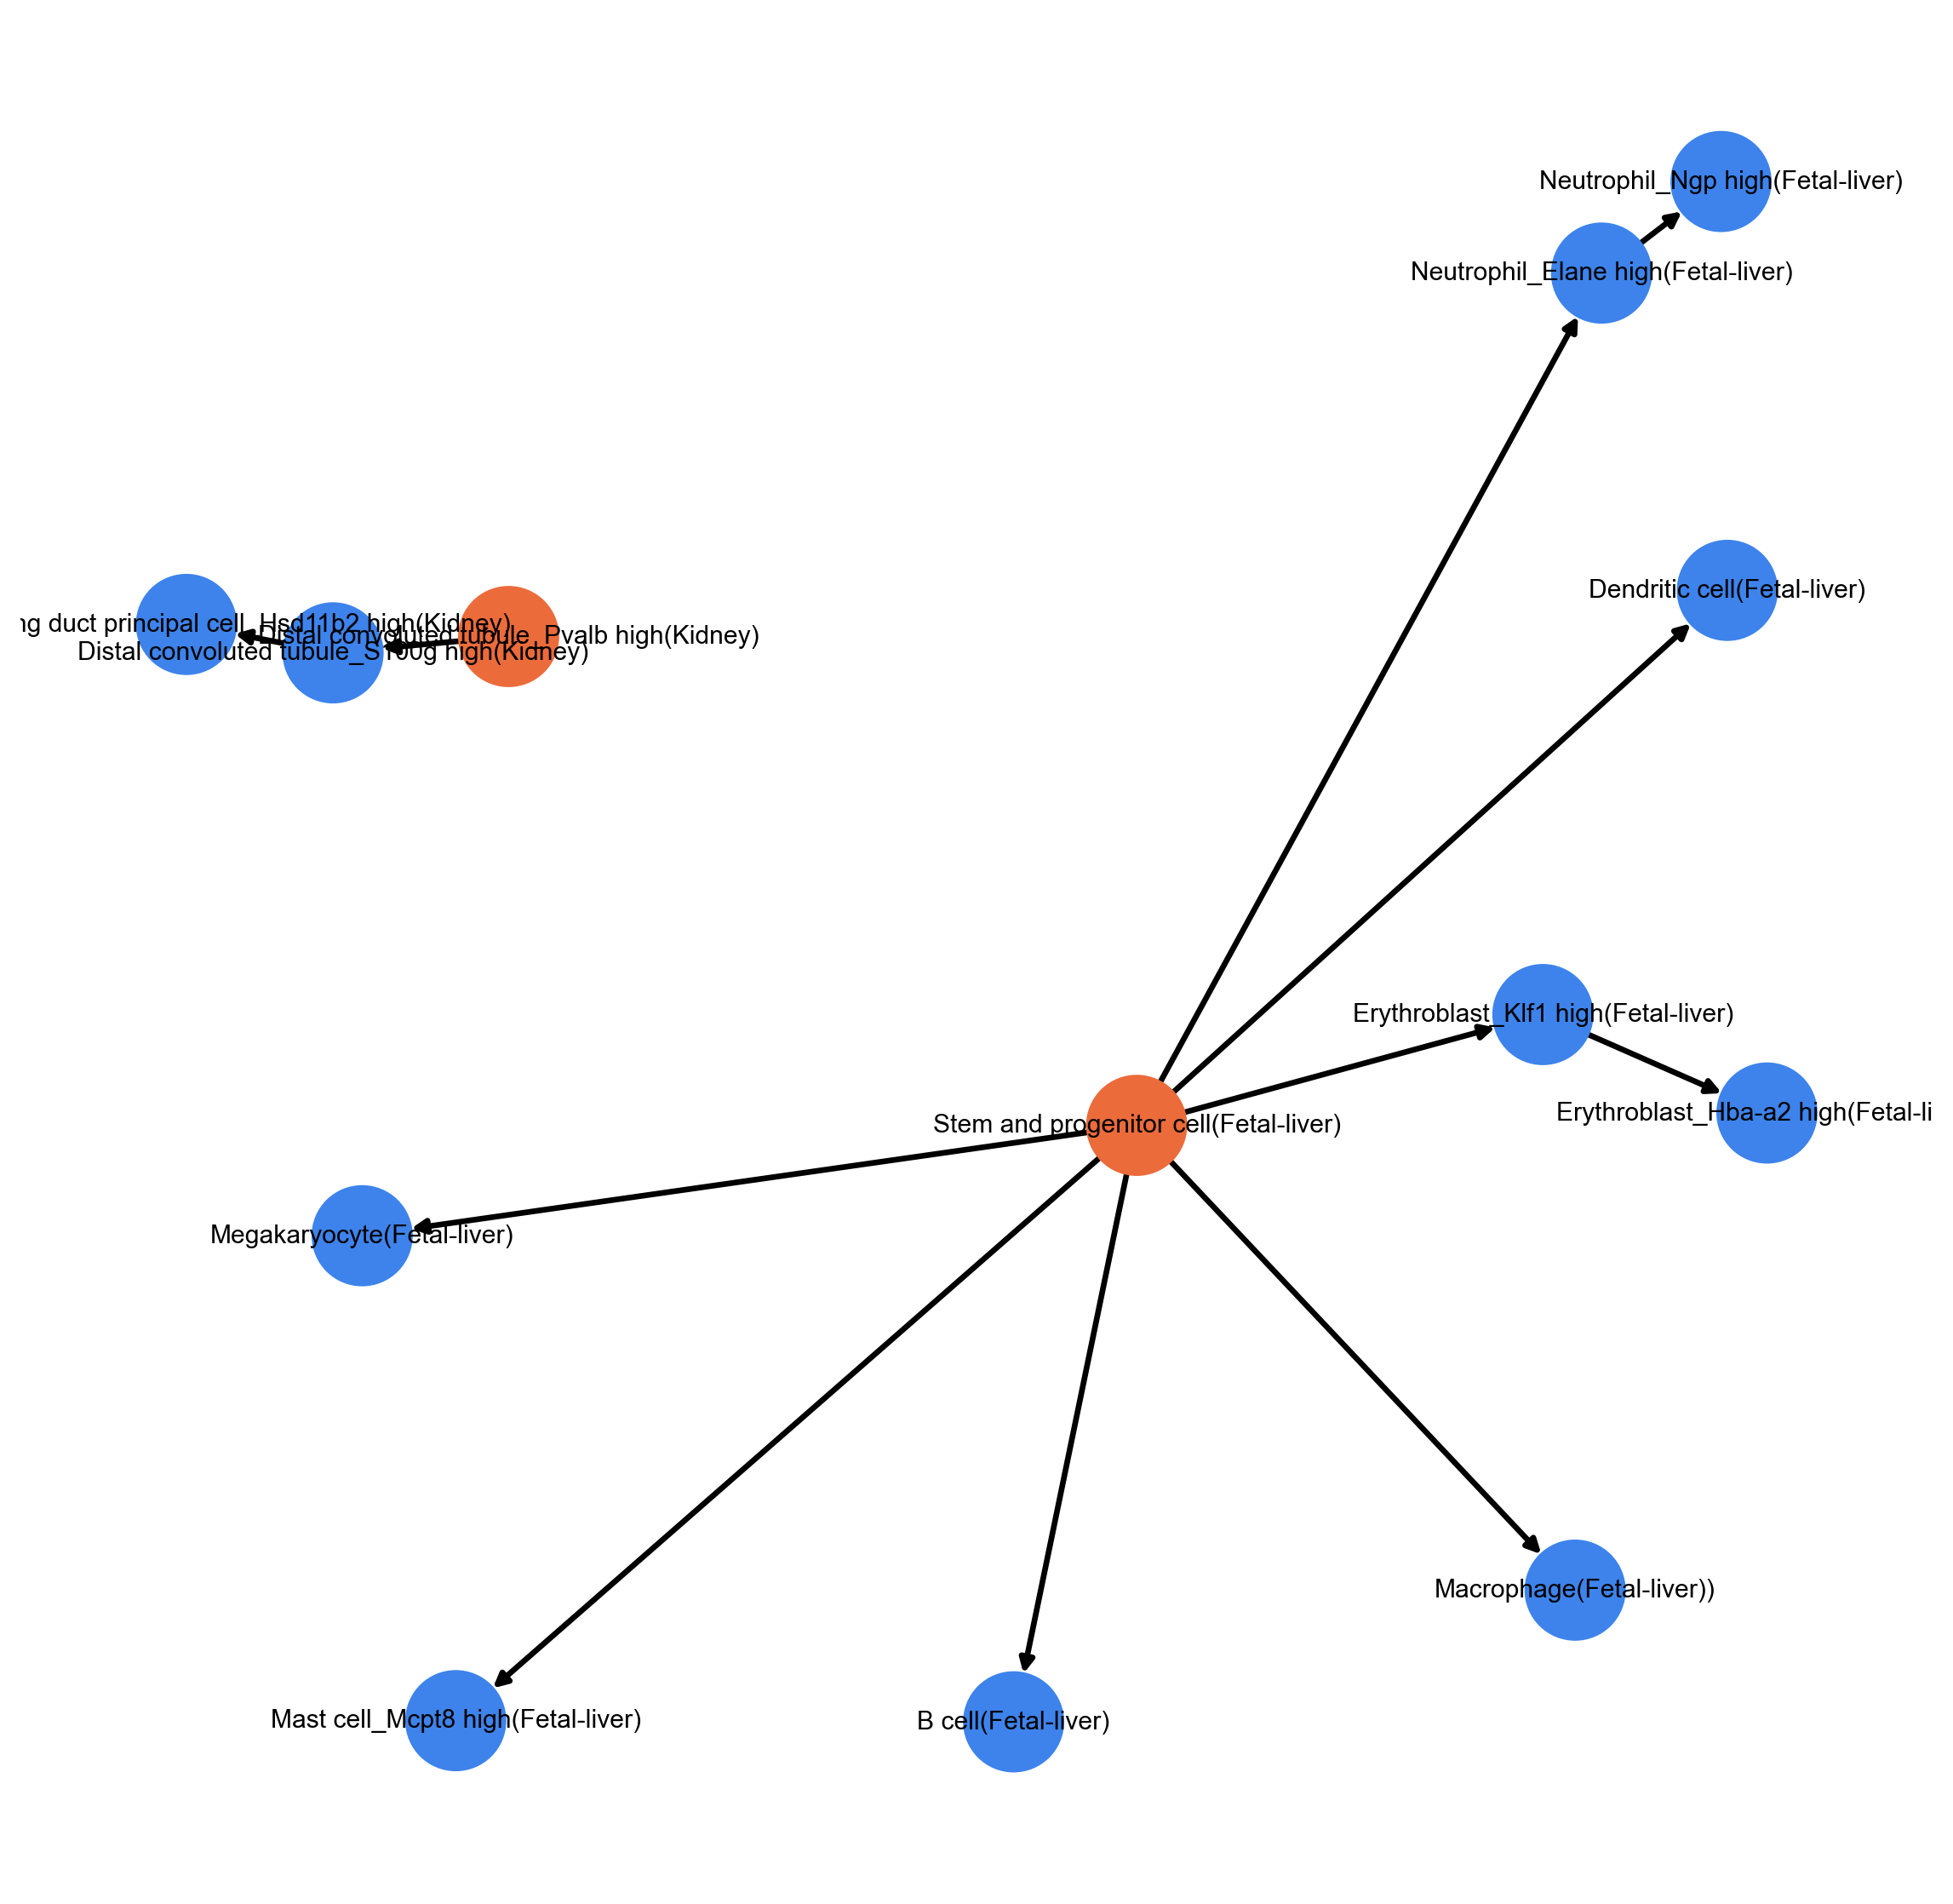

In [10]:
from utils.plot import plot_gt_milestone_network

plot_gt_milestone_network(adata, start_node_color='#EB6B3B', node_color='#3D83EB', node_size=1200)

In [11]:
# Extract the index of the start cell(s) from adata.obs_names
start_ids = [np.where(adata.obs_names == start_id)[0][0] for start_id in np.atleast_1d(adata.uns['start_id'])]
start_ids

[2871, 2297]

In [12]:
from utils.util import preprocess_recipe

# Preprocessing using Seurat default parameters
min_expr_level = 3
min_cells = None
use_hvg = False
n_top_genes = 1000
preprocessed_data = preprocess_recipe(
    adata,
    min_expr_level=min_expr_level,
    min_cells=min_cells,
    use_hvg=use_hvg,
    n_top_genes=n_top_genes,
    scale=True
)

Preprocessing....
	->Removed cells with expression level<3
	->Normalized data
	->Applying z-score normalization
Pre-processing complete. Updated data shape: (3211, 2218)
Runtime for preprocess_recipe(): 0.15201663970947266


In [13]:
from utils.util import run_pca

# Apply PCA on the raw data for initial denoising
print('Computing PCA...')
X_pca, _, n_comps = run_pca(preprocessed_data, use_hvg=False, n_components=10)
preprocessed_data.obsm['X_pca'] = X_pca
print(f'Components computed: {n_comps}')

Computing PCA...
Runtime for run_pca(): 0.12942981719970703
Components computed: 10


In [14]:
gt_clusters = pd.Series(index=preprocessed_data.obs_names)

In [15]:
for obs_name in preprocessed_data.obs_names:
    res = (preprocessed_data.uns['milestone_percentages']['cell_id'] == obs_name)
    milestones = preprocessed_data.uns['milestone_percentages'].loc[res, 'milestone_id']
    percentages = preprocessed_data.uns['milestone_percentages'].loc[res, 'percentage']
    cluster_id = milestones.loc[percentages.idxmax()]
    gt_clusters.loc[obs_name] = cluster_id

In [16]:
preprocessed_data.obs['gt_clusters'] = gt_clusters

# VIA

In [17]:
import pyVIA.core as via

In [18]:
resolution = 1.0

In [19]:
# v0 = via.VIA(preprocessed_data.obsm['X_pca'], preprocessed_data.obs['gt_clusters'], jac_std_global=0.15, dist_std_local=1, knn=30,
#              too_big_factor=0.3, root_user=start_ids, dataset='', random_seed=0, resolution_parameter=resolution, preserve_disconnected=True)  # *.4 root=1,
# v0.run_VIA()

In [20]:
v0 = via.VIA(
    preprocessed_data.obsm['X_pca'],
    preprocessed_data.obs['gt_clusters'],
    # jac_std_global=0.15,
    # dist_std_local=1,
    knn=30,
    too_big_factor=0.3,
    root_user=start_ids,
    dataset='',
    random_seed=0,
    resolution_parameter=resolution,
)
v0.run_VIA()

2025-04-15 01:12:54.985478	Running VIA over input data of 3211 (samples) x 10 (features)
2025-04-15 01:12:54.985631	Knngraph has 30 neighbors
2025-04-15 01:12:55.994809	Finished global pruning of 30-knn graph used for clustering at level of 0.15. Kept 47.0 % of edges. 
2025-04-15 01:12:56.011338	Number of connected components used for clustergraph  is 2
2025-04-15 01:12:56.150333	Commencing community detection
2025-04-15 01:12:56.419711	Finished community detection. Found 58 clusters.
2025-04-15 01:12:56.421072	Merging 41 very small clusters (<10)
2025-04-15 01:12:56.422328	Finished detecting communities. Found 17 communities
2025-04-15 01:12:56.422519	Making cluster graph. Global cluster graph pruning level: 0.15
2025-04-15 01:12:56.430952	Graph has 2 connected components before pruning
2025-04-15 01:12:56.433240	Graph has 5 connected components after pruning
2025-04-15 01:12:56.436512	Graph has 2 connected components after reconnecting
2025-04-15 01:12:56.437223	0.0% links trimmed fr

/home/satwik/dynooenv/lib/python3.12/site-packages/pyVIA/core.py:176: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  g.set_node_ids(node_ids=None,


  0%|          | 0/1300 [00:00<?, ?it/s]

memory for rw2 hittings times  2. Using rw2 based pt
2025-04-15 01:13:02.804750	Identifying terminal clusters corresponding to unique lineages...
2025-04-15 01:13:02.804803	Closeness:[4, 7, 8, 10, 11, 12]
2025-04-15 01:13:02.804813	Betweenness:[0, 3, 4, 6, 8, 9, 11, 12]
2025-04-15 01:13:02.804819	Out Degree:[0, 3, 4, 6, 8, 9, 11, 12]
2025-04-15 01:13:02.804954	We removed cluster 12 from the shortlist of terminal states
2025-04-15 01:13:02.805026	Terminal clusters corresponding to unique lineages in this component are [0, 3, 6, 8, 9, 11] 
2025-04-15 01:13:02.805037	Calculating lineage probability at memory 5


/home/satwik/dynooenv/lib/python3.12/site-packages/pyVIA/core.py:176: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  g.set_node_ids(node_ids=None,


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-15 01:13:06.508794	Cluster or terminal cell fate 0 is reached 7.0 times
2025-04-15 01:13:06.530307	Cluster or terminal cell fate 3 is reached 18.0 times
2025-04-15 01:13:06.553797	Cluster or terminal cell fate 6 is reached 17.0 times
2025-04-15 01:13:06.572687	Cluster or terminal cell fate 8 is reached 137.0 times
2025-04-15 01:13:06.592298	Cluster or terminal cell fate 9 is reached 14.0 times
2025-04-15 01:13:06.607169	Cluster or terminal cell fate 11 is reached 979.0 times
2025-04-15 01:13:06.609938	component number 1 out of  [0, 1]
2025-04-15 01:13:06.612055	The root index, 2871 provided by the user belongs to cluster number 4 and corresponds to cell type Distal convoluted tubule_Pvalb high(Kidney)
2025-04-15 01:13:06.613098	Computing lazy-teleporting expected hitting times


/home/satwik/dynooenv/lib/python3.12/site-packages/pyVIA/core.py:2479: RuntimeWarning: invalid value encountered in divide
  bp_array = bp_array / bp_array.sum(axis=1)[:, None]  # row normalization at the cluster level
/home/satwik/dynooenv/lib/python3.12/site-packages/pyVIA/core.py:176: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  g.set_node_ids(node_ids=None,


2025-04-15 01:13:06.776612	Ended all multiprocesses, will retrieve and reshape
2025-04-15 01:13:06.811271	start computing walks with rw2 method


  0%|          | 0/1300 [00:00<?, ?it/s]

memory for rw2 hittings times  2. Using rw2 based pt
2025-04-15 01:13:09.551127	Identifying terminal clusters corresponding to unique lineages...
2025-04-15 01:13:09.551167	Closeness:[0, 3]
2025-04-15 01:13:09.551180	Betweenness:[0, 3]
2025-04-15 01:13:09.551187	Out Degree:[1, 3]
2025-04-15 01:13:09.551440	Terminal clusters corresponding to unique lineages in this component are [3] 
2025-04-15 01:13:09.551461	Calculating lineage probability at memory 5


/home/satwik/dynooenv/lib/python3.12/site-packages/pyVIA/core.py:176: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  g.set_node_ids(node_ids=None,


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-15 01:13:12.346507	Cluster or terminal cell fate 3 is reached 1000.0 times
2025-04-15 01:13:12.349137	There are (7) terminal clusters corresponding to unique lineages {0: 'Erythroblast_Klf1 high(Fetal-liver)', 3: 'Erythroblast_Klf1 high(Fetal-liver)', 8: 'Erythroblast_Klf1 high(Fetal-liver)', 10: 'Dendritic cell(Fetal-liver)', 11: 'Erythroblast_Klf1 high(Fetal-liver)', 15: 'Neutrophil_Ngp high(Fetal-liver)', 13: 'Distal collecting duct principal cell_Hsd11b2 high(Kidney)'}
2025-04-15 01:13:12.349189	Begin projection of pseudotime and lineage likelihood
2025-04-15 01:13:12.661729	Cluster graph layout based on forward biasing
2025-04-15 01:13:12.664146	Starting make edgebundle viagraph...
2025-04-15 01:13:12.664164	Make via clustergraph edgebundle
2025-04-15 01:13:12.889683	Hammer dims: Nodes shape: (17, 2) Edges shape: (42, 3)
2025-04-15 01:13:12.890564	Graph has 2 connected components before pruning
2025-04-15 01:13:12.891484	Graph has 6 connected components after pruning
2025-

In [21]:
import networkx as nx

via_graph = nx.Graph()

for pair in v0.edgelist:
    n1, n2 = pair
    via_graph.add_edge(n1, n2)

In [22]:
from metrics.ipsen import IpsenMikhailov
from models.ti.graph import compute_gt_milestone_network


gt_graph = net1 = compute_gt_milestone_network(preprocessed_data, mode="undirected")
im = IpsenMikhailov()
dist = im(via_graph, gt_graph)

print(dist)

Runtime for compute_gt_milestone_network(): 0.001558542251586914
0.5972902563086715


In [23]:
from metrics.ordering import compute_ranking_correlation


via_pt = v0.single_cell_pt_markov
gt_pseudotime = preprocessed_data.uns["timecourse"].reindex(preprocessed_data.obs_names)

res = compute_ranking_correlation(gt_pseudotime, via_pt)
print(res)

{'kendall': SignificanceResult(statistic=0.5460599834625475, pvalue=7.2222880687157e-310), 'weighted_kendall': SignificanceResult(statistic=0.7829753256681995, pvalue=nan), 'spearman': SignificanceResult(statistic=0.6430395215659322, pvalue=0.0)}


In [24]:
print(via_pt)

[0.5430280652485967, 0.5430280652485967, 0.5430280652485967, 0.5430280652485967, 0.5430280652485967, 0.5430280652485967, 0.5430280652485967, 0.5430280652485967, 0.5430280652485967, 1.0, 0.5430280652485967, 0.0, 0.5430280652485967, 0.07506205619624551, 0.0, 0.5430280652485967, 0.5430280652485967, 0.5430280652485967, 0.5430280652485967, 0.07506205619624551, 0.07506205619624551, 0.5430280652485967, 0.5430280652485967, 0.5514042907697143, 0.5430280652485967, 0.5430280652485967, 0.5430280652485967, 1.0, 1.0, 0.6953520434990644, 0.5430280652485967, 1.0, 0.5430280652485967, 1.0, 1.0, 0.07506205619624551, 0.5430280652485967, 0.5430280652485967, 0.5430280652485967, 1.0, 0.5430280652485967, 1.0, 0.56241781545833, 0.5430280652485967, 0.16662596264240292, 0.5430280652485967, 1.0, 0.5430280652485967, 0.5430280652485967, 0.5430280652485967, 1.0, 0.5430280652485967, 0.5430280652485967, 1.0, 0.0, 0.5430280652485967, 0.5430280652485967, 1.0, 0.5430280652485967, 0.5430280652485967, 0.5430280652485967, 0

# Via metrics

In [25]:
%%R
dataset <- readRDS("mouse-cell-atlas-combination-2.rds")

In [26]:
%%R
library(dyndimred)
pca_dimred <- dimred_pca(
  dataset$expression
)

In [27]:
%%R
v_dataset <- readRDS("mouse-cell-atlas-combination-2.rds")

In [28]:
cell_ids = preprocessed_data.obs_names.to_list()
v_pseudotime = pd.Series(v0.single_cell_pt_markov, index=cell_ids)
v_milestone_ids = [i for i in range(len(set(v0.labels)))]
v_hard_clusters = v0.labels

In [29]:
fromlist = []
tolist = []
for t in v0.edgelist:
    if(t[0] > t[1]):
        continue
    fromlist.append(str(t[0]))
    tolist.append(str(t[1]))
v_edges_df = pd.DataFrame({'from': fromlist, 'to': tolist, 'length': 1, 'directed': False})
v_edges_df

,from,to,length,directed
0,0,2,1,False
1,0,6,1,False
2,1,2,1,False
3,1,3,1,False
4,1,6,1,False
5,1,8,1,False
6,1,11,1,False
7,2,6,1,False
8,2,9,1,False
9,3,8,1,False


In [30]:
for i in range(len(v_milestone_ids)):
    v_milestone_ids[i] = str(v_milestone_ids[i])

In [31]:
labels = v0.labels.copy()
for i in range(len(labels)):
    labels[i] = str(labels[i])
v_milestone_percentages = pd.DataFrame({'cell_id': cell_ids, 'milestone_id': labels, 'percentage': [1 for i in range(len(labels))]})

In [32]:
%%R -i cell_ids -i v_pseudotime -i v_milestone_ids -i v_milestone_percentages -i v_edges_df
v_traj <- add_trajectory(
  v_dataset,
  cell_ids = cell_ids,
  pseudotime = v_pseudotime,
  milestone_ids = as.vector(v_milestone_ids),
  milestone_percentages = v_milestone_percentages,
  milestone_network = v_edges_df
)

In [34]:
%%R
name_mapping <- c(
  "Erythroblast_Klf1 high(Fetal-liver)" = "Erythro_Klf1",
  "Stem and progenitor cell(Fetal-liver)" = "Stem/Prog",
  "Neutrophil_Elane high(Fetal-liver)" = "Neutro_Elane",
  "Megakaryocyte(Fetal-liver)" = "Megakaryo",
  "B cell(Fetal-liver)" = "B_cell",
  "Neutrophil_Ngp high(Fetal-liver)" = "Neutro_Ngp",
  "Dendritic cell(Fetal-liver)" = "DC",
  "Erythroblast_Hba-a2 high(Fetal-liver)" = "Erythro_Hba-a2",
  "Mast cell_Mcpt8 high(Fetal-liver)" = "Mast_Mcpt8",
  "Distal convoluted tubule_Pvalb high(Kidney)" = "DCT_Pvalb",
  "Distal convoluted tubule_S100g high(Kidney)" = "DCT_S100g",
  "Distal collecting duct principal cell_Hsd11b2 high(Kidney)" = "CCD_Hsd11b2"
)

In [35]:
%%R
library(RColorBrewer)
palette <- brewer.pal(n = length(unique(dataset$grouping)), name = "Set3")

In [36]:
%%R
library(dplyr)
groups <- recode(dataset$grouping, !!!name_mapping)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


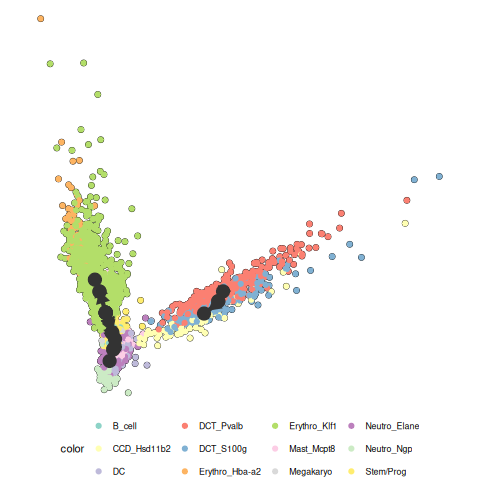

In [37]:
%%R
plot_dimred(dataset, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


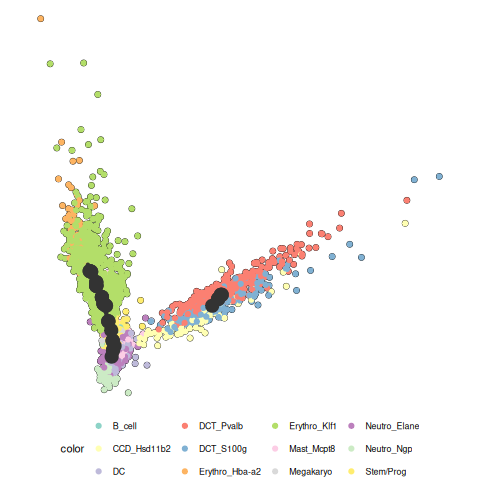

In [38]:
%%R

plot_dimred(v_traj, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

In [39]:
%%R
library(dyneval)

In [40]:
%%R
via_metrics <- calculate_metrics(
  dataset = v_dataset,
  model = v_traj,
  metrics = dyneval::metrics$metric_id,
  expression_source = v_dataset$expression
)

In addition: Warning message:
`data_frame()` was deprecated in tibble 1.1.0.
ℹ Please use `tibble()` instead.
ℹ The deprecated feature was likely used in the dyneval package.
  Please report the issue to the authors.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


In [41]:
%%R
cat("HIM =", via_metrics$him, "\n")
cat("F1_branches =", via_metrics$F1_branches, "\n")
cat("correlation =", via_metrics$correlation, "\n")
cat("featureimp_wcor =", via_metrics$featureimp_wcor, "\n")
v_selected_metrics <- c(
  him = as.numeric(via_metrics$him),
  F1_branches = via_metrics$F1_branches,
  correlation = via_metrics$correlation,
  featureimp_wcor = via_metrics$featureimp_wcor
)
v_overall_score <- exp(mean(log(v_selected_metrics)))
cat("overall_score =", v_overall_score, "\n")

HIM = 0.6725629 
F1_branches = 0.3869579 
correlation = 0.9148116 
featureimp_wcor = 0.5772818 
overall_score = 0.6088763 


# margaret

In [39]:
import warnings
from train_metric import train_metric_learner

with warnings.catch_warnings():
    # Filter out user warnings from PyTorch about saving scheduler state
    warnings.simplefilter("ignore")
    train_metric_learner(preprocessed_data, n_episodes=10, n_metric_epochs=10, obsm_data_key='X_pca', code_size=10,
        backend='leiden', device='cpu', save_path='metric',
        # cluster_kwargs={'random_state': 0, 'n_clusters': 30}, nn_kwargs={'random_state': 0, 'n_neighbors': 10},
        cluster_kwargs={'random_state': 0, 'resolution': 1.0}, nn_kwargs={'random_state': 0, 'n_neighbors': 30},
        trainer_kwargs={
            'optimizer': 'SGD',
            'lr': 0.01,
            'batch_size': 256,
            'train_loader_kwargs': {'num_workers': 2, 'pin_memory': True, 'drop_last': True}
        },
        loss_kwargs={
            'margin': 1.0,
            'p': 2
        }
    )

Generating initial clusters
Runtime for determine_cell_clusters(): 4.156419992446899
Training for episode: 1


100%|██████████| 3211/3211 [00:00<00:00, 10609.98it/s]


Re-generating clusters for episode: 1
Runtime for determine_cell_clusters(): 1.3550775051116943
Time Elapsed for epoch: 12.796778202056885s
Training for episode: 2


100%|██████████| 3211/3211 [00:00<00:00, 7364.18it/s]


Re-generating clusters for episode: 2
Runtime for determine_cell_clusters(): 1.478872537612915
Time Elapsed for epoch: 12.806124925613403s
Training for episode: 3


100%|██████████| 3211/3211 [00:00<00:00, 11290.83it/s]


Re-generating clusters for episode: 3
Runtime for determine_cell_clusters(): 0.9371175765991211
Time Elapsed for epoch: 13.817734241485596s
Training for episode: 4


100%|██████████| 3211/3211 [00:00<00:00, 11959.65it/s]


Re-generating clusters for episode: 4
Runtime for determine_cell_clusters(): 0.980830192565918
Time Elapsed for epoch: 11.964914321899414s
Training for episode: 5


100%|██████████| 3211/3211 [00:00<00:00, 12633.20it/s]


Re-generating clusters for episode: 5
Runtime for determine_cell_clusters(): 1.0721549987792969
Time Elapsed for epoch: 11.253156185150146s
Training for episode: 6


100%|██████████| 3211/3211 [00:00<00:00, 11826.30it/s]


Re-generating clusters for episode: 6
Runtime for determine_cell_clusters(): 0.9098730087280273
Time Elapsed for epoch: 12.282026767730713s
Training for episode: 7


100%|██████████| 3211/3211 [00:00<00:00, 9014.70it/s]


Re-generating clusters for episode: 7
Runtime for determine_cell_clusters(): 1.0308058261871338
Time Elapsed for epoch: 14.397688865661621s
Training for episode: 8


100%|██████████| 3211/3211 [00:00<00:00, 9913.07it/s] 


Re-generating clusters for episode: 8
Runtime for determine_cell_clusters(): 0.9853980541229248
Time Elapsed for epoch: 13.180979251861572s
Training for episode: 9


100%|██████████| 3211/3211 [00:00<00:00, 11101.56it/s]


Re-generating clusters for episode: 9
Runtime for determine_cell_clusters(): 1.0193369388580322
Time Elapsed for epoch: 10.071330308914185s
Training for episode: 10


100%|██████████| 3211/3211 [00:00<00:00, 12738.15it/s]


Re-generating clusters for episode: 10
Runtime for determine_cell_clusters(): 1.278592824935913
Time Elapsed for epoch: 11.101747989654541s
Runtime for train_metric_learner(): 129.74203968048096


In [40]:
from utils.plot import generate_plot_embeddings, plot_gene_expression, plot_embeddings, plot_clusters
import matplotlib.pyplot as plt

In [41]:
X_embedded = generate_plot_embeddings(preprocessed_data.obsm['metric_embedding'], method='umap', random_state=random_seed)
preprocessed_data.obsm['X_met_embedding'] = X_embedded

/home/satwik/dynooenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Runtime for generate_plot_embeddings(): 22.70284628868103


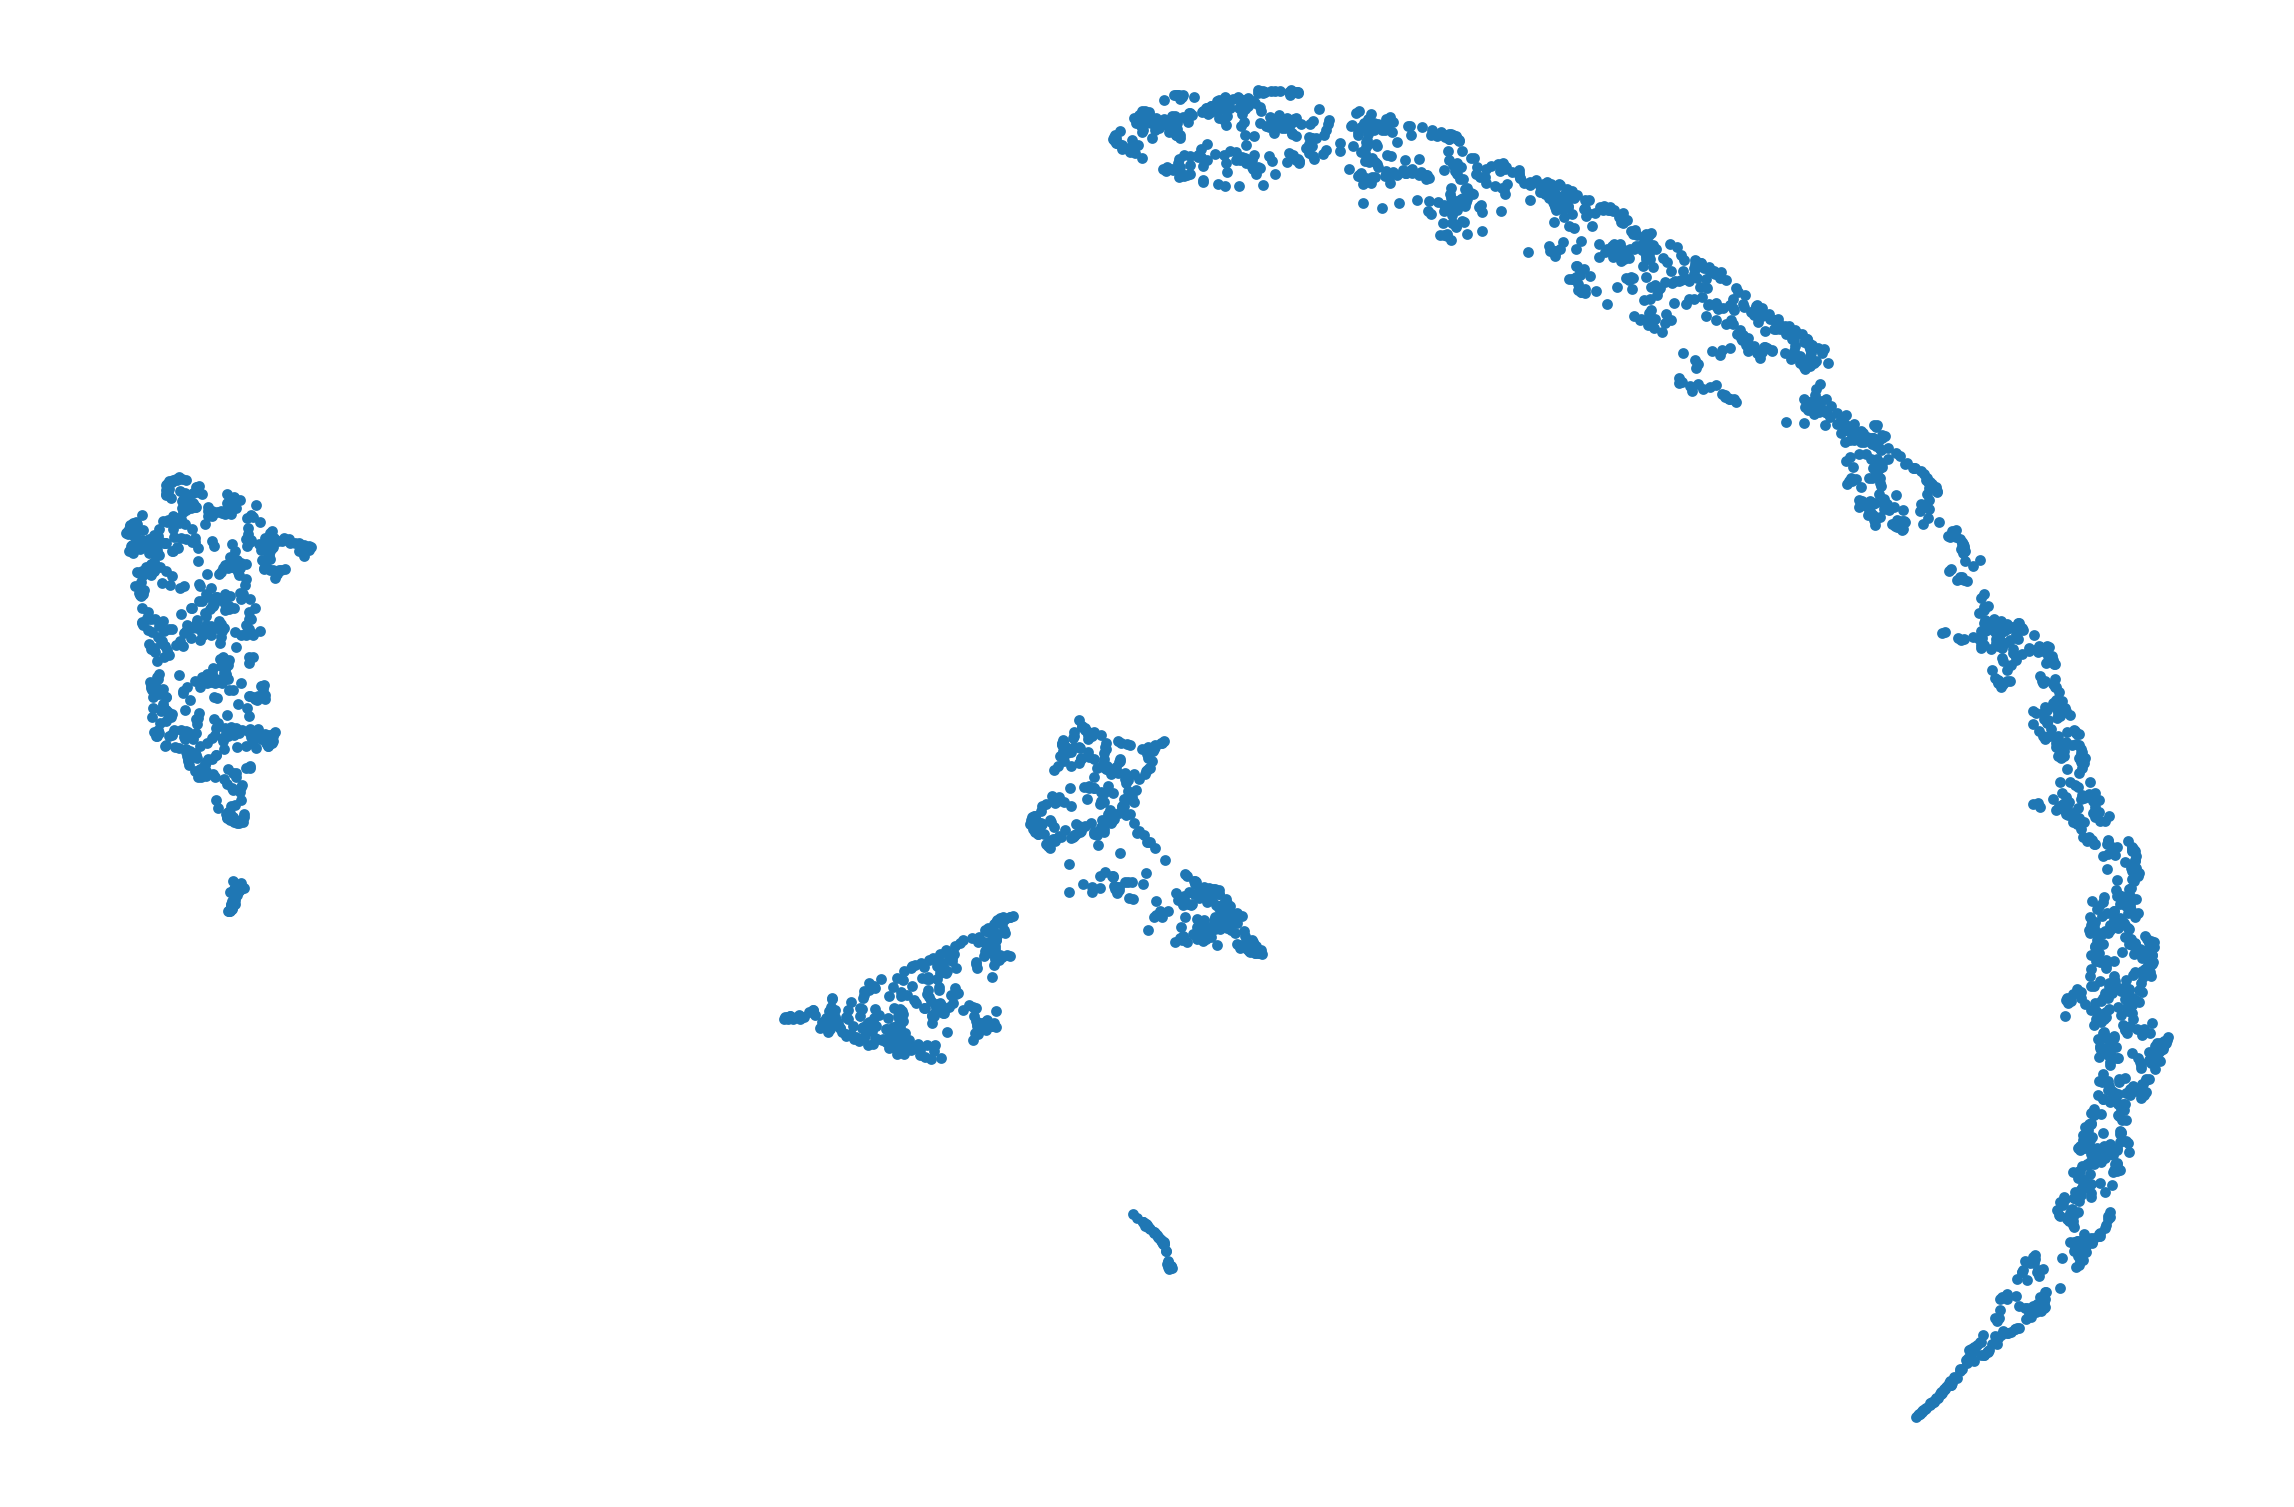

In [42]:
plot_embeddings(X_embedded, s=5)

In [43]:
import numpy as np

from sklearn.neighbors import NearestNeighbors

from models.ti.connectivity import compute_directed_cluster_connectivity, compute_undirected_cluster_connectivity
from models.ti.graph import compute_trajectory_graph, compute_connectivity_graph
from utils.plot import plot_connectivity_graph, plot_trajectory_graph, plot_connectivity_graph_with_gene_expressions
from utils.util import get_start_cell_cluster_id

In [44]:
communities = preprocessed_data.obs['metric_clusters'].to_numpy().astype(int)

In [45]:
X = preprocessed_data.obsm['metric_embedding']

n_neighbors = 50
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X)
adj_dist = nbrs.kneighbors_graph(X, mode="distance")
adj_conn = nbrs.kneighbors_graph(X)

In [46]:
start_cell_ids = preprocessed_data.uns['start_id']
start_cluster_ids = get_start_cell_cluster_id(preprocessed_data, start_cell_ids, communities)
start_cluster_ids

{3, 8}

In [47]:
un_connectivity, un_z_score = compute_undirected_cluster_connectivity(communities, adj_conn, z_threshold=0.6)
pd.DataFrame(un_z_score)

Runtime for compute_undirected_cluster_connectivity(): 0.2618987560272217


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,-1.109878,-1.104596,-1.098415,5.667628,-1.100284,-1.100414,-1.093788,-1.079450,6.627970,-1.089269,-1.096053,-1.080845,-1.071681,-1.082567,-1.066923
1,-1.109878,0.000000,-1.103096,9.932104,-1.095200,-1.097417,-1.097360,-1.090748,-1.085216,-1.087164,-1.085459,-1.092263,-1.077217,-1.067911,9.589888,-1.061811
2,-1.104596,-1.103096,0.000000,-1.093849,-1.092619,-1.093992,-1.093775,-1.089255,5.672374,-1.086421,-1.085159,-1.089976,5.289871,-1.070850,-1.079362,7.820191
3,-1.098415,9.932104,-1.093849,0.000000,-1.083768,-1.084296,-1.083464,-1.080210,-1.077388,-1.075824,-1.074736,-1.078478,-1.069539,-1.062067,-1.067094,-1.055403
4,5.667628,-1.095200,-1.092619,-1.083768,0.000000,-1.079354,-1.077858,-1.075060,-0.944333,-1.068561,6.984038,-0.786332,-1.062940,-1.055069,-1.056607,-1.044990
5,-1.100284,-1.097417,-1.093992,-1.084296,-1.079354,0.000000,7.073611,-1.074419,-1.072256,-1.066644,-1.065481,6.889320,-1.060927,-1.052566,-1.052241,-1.040370
6,-1.100414,-1.097360,-1.093775,-1.083464,-1.077858,7.073611,0.000000,9.329519,-1.009933,-1.063760,-1.062657,-0.992851,-1.058639,-1.050237,-1.047671,-1.036459
7,-1.093788,-1.090748,-1.089255,-1.080210,-1.075060,-1.074419,9.329519,0.000000,-0.657417,-1.064223,-1.063368,-1.065500,-1.059930,-1.052687,-1.052509,-1.042316
8,-1.079450,-1.085216,5.672374,-1.077388,-0.944333,-1.072256,-1.009933,-0.657417,0.000000,-1.064803,-1.064149,-0.042788,8.301691,-1.055216,-1.056354,-1.047653
9,6.627970,-1.087164,-1.086421,-1.075824,-1.068561,-1.066644,-1.063760,-1.064223,-1.064803,0.000000,-1.054335,-1.054343,-1.052856,12.376681,-1.040147,-1.032133


Runtime for compute_connectivity_graph(): 0.008934497833251953


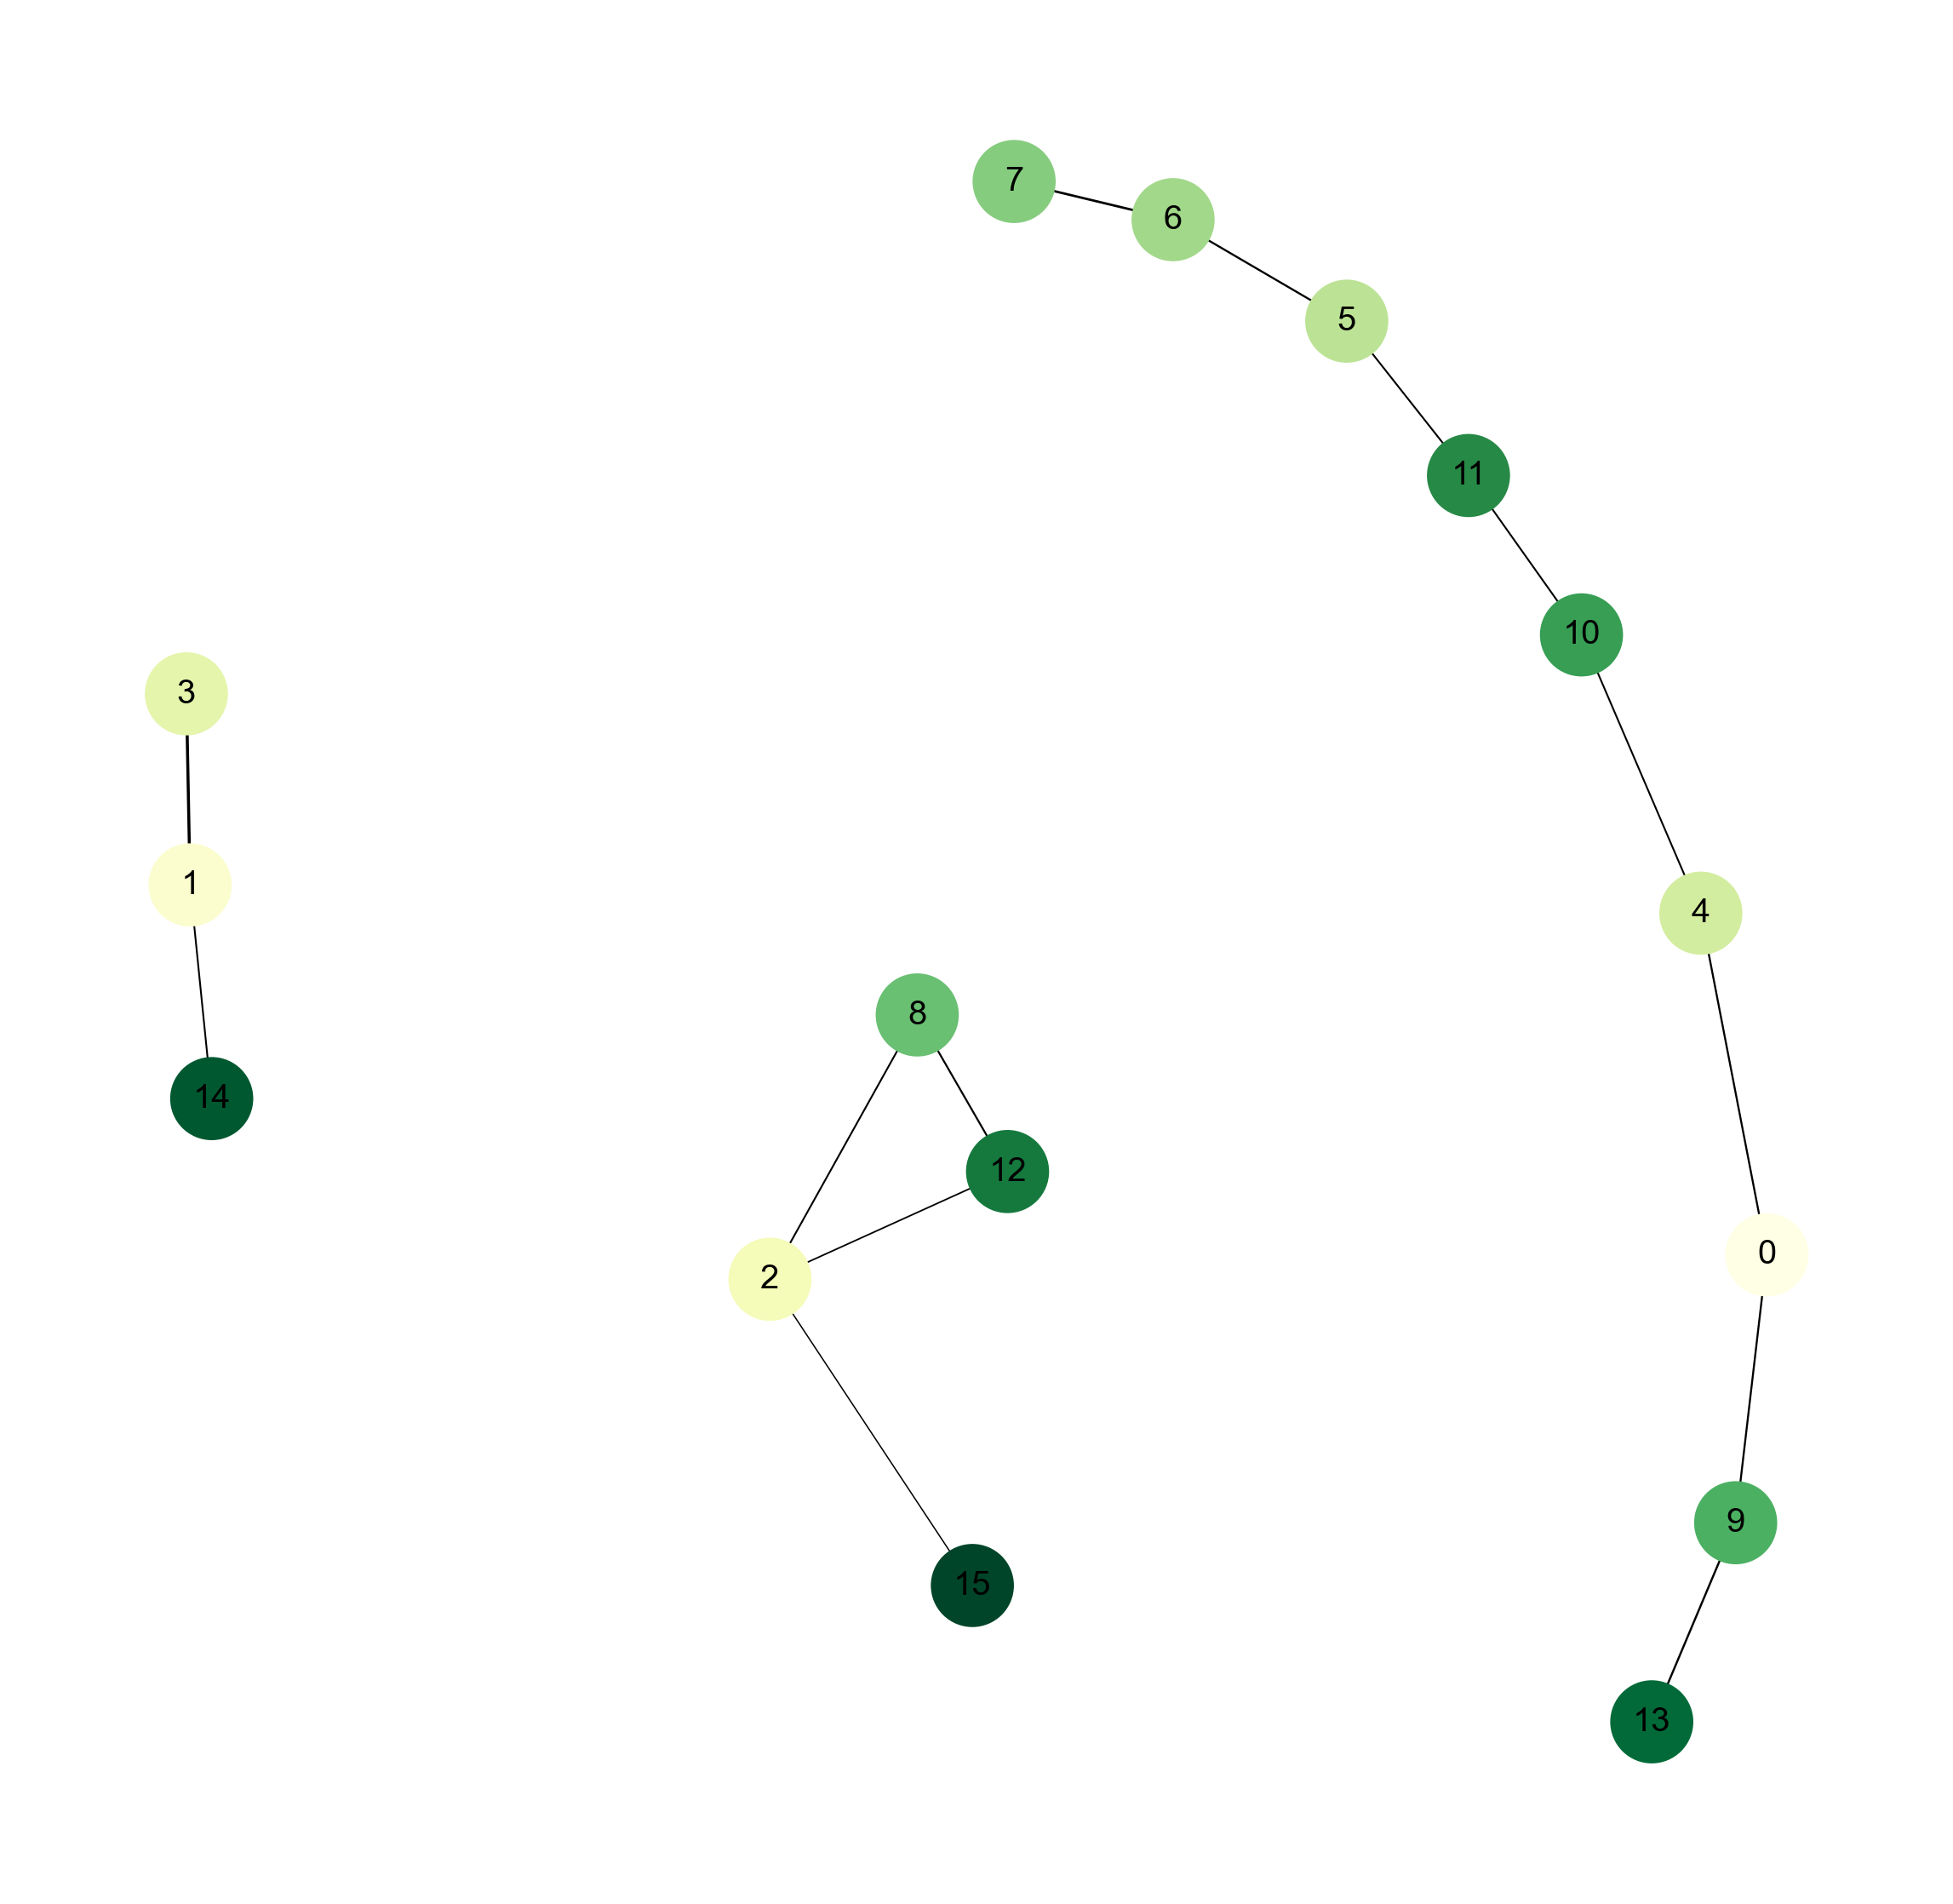

In [48]:
plot_connectivity_graph(preprocessed_data.obsm['X_met_embedding'], communities, un_connectivity, mode='undirected', offset=0.2)

In [49]:
connectivity, z_score = compute_directed_cluster_connectivity(communities, adj_conn, threshold=0.8)

Runtime for compute_directed_cluster_connectivity(): 0.10322022438049316


In [50]:
import networkx as nx

from sklearn.neighbors import NearestNeighbors

from models.ti.pseudotime import compute_pseudotime
from models.ti.pseudotime_v2 import compute_pseudotime
from models.ti.graph import compute_trajectory_graph_v2
from utils.plot import plot_trajectory_graph_v2
from utils.plot import plot_pseudotime

In [51]:
# v2 pseudotime
G_undirected, node_positions = compute_connectivity_graph(preprocessed_data.obsm['X_met_embedding'], preprocessed_data.obs['metric_clusters'], un_connectivity)
adj_cluster = nx.to_pandas_adjacency(G_undirected)
pseudotime = compute_pseudotime(preprocessed_data, start_cell_ids, adj_dist, adj_cluster)

Runtime for compute_connectivity_graph(): 0.0068166255950927734
Runtime for compute_pseudotime(): 1.331702470779419


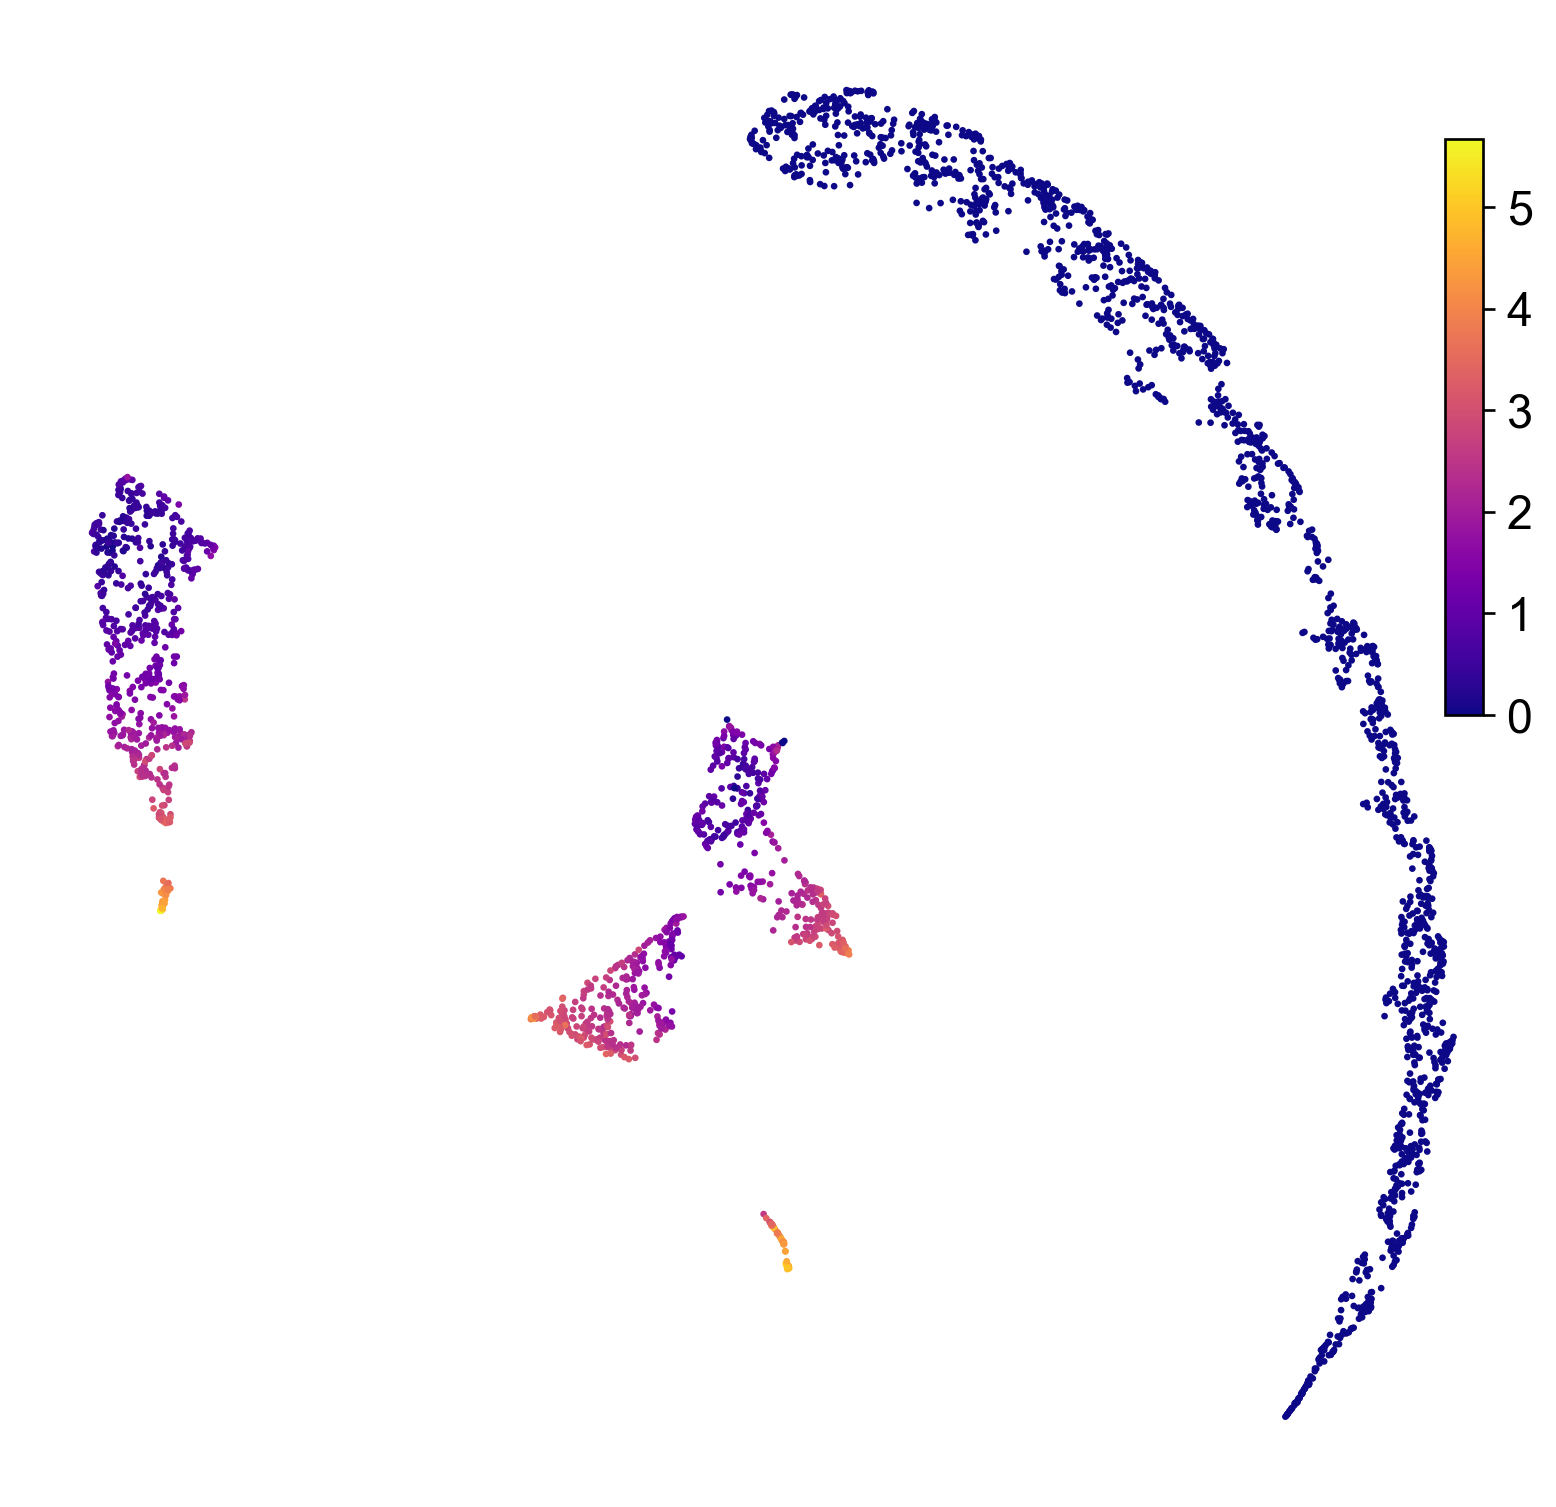

In [52]:
plot_pseudotime(
    preprocessed_data,
    embedding_key="X_met_embedding",
    pseudotime_key="metric_pseudotime_v2",
    s=1,
    cmap='plasma',
    figsize=(8, 8),
    cb_axes_pos=[0.92, 0.55, 0.02, 0.3]
)

In [53]:
# Compute directed graph v2
G_directed_v2 = compute_trajectory_graph_v2(pseudotime, adj_cluster, preprocessed_data.obs['metric_clusters'], connectivity)

Runtime for compute_trajectory_graph_v2(): 0.01700592041015625


In [54]:
color_map = {
    0: '#FA6B66',
    1: '#A6A78F',
    2: '#A6A78F',
    3: '#A6A78F',
    4: '#A6A78F',
    5: '#6EAAAF',
    6: '#6EAAAF',
    7: '#6EAAAF',
    8: '#6EAAAF',
    9: '#6EAAAF',
    10: '#A6A78F'
}
color_map = {f'{idx}': '#A6A78F' for idx in range(22)}
color_map['16'] = '#FA6B66'
color_map['1'] = '#FA6B66'
color_map['0'] = '#FA6B66'

color_map['18'] = '#6EAAAF'
color_map['11'] = '#6EAAAF'
color_map['17'] = '#6EAAAF'

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


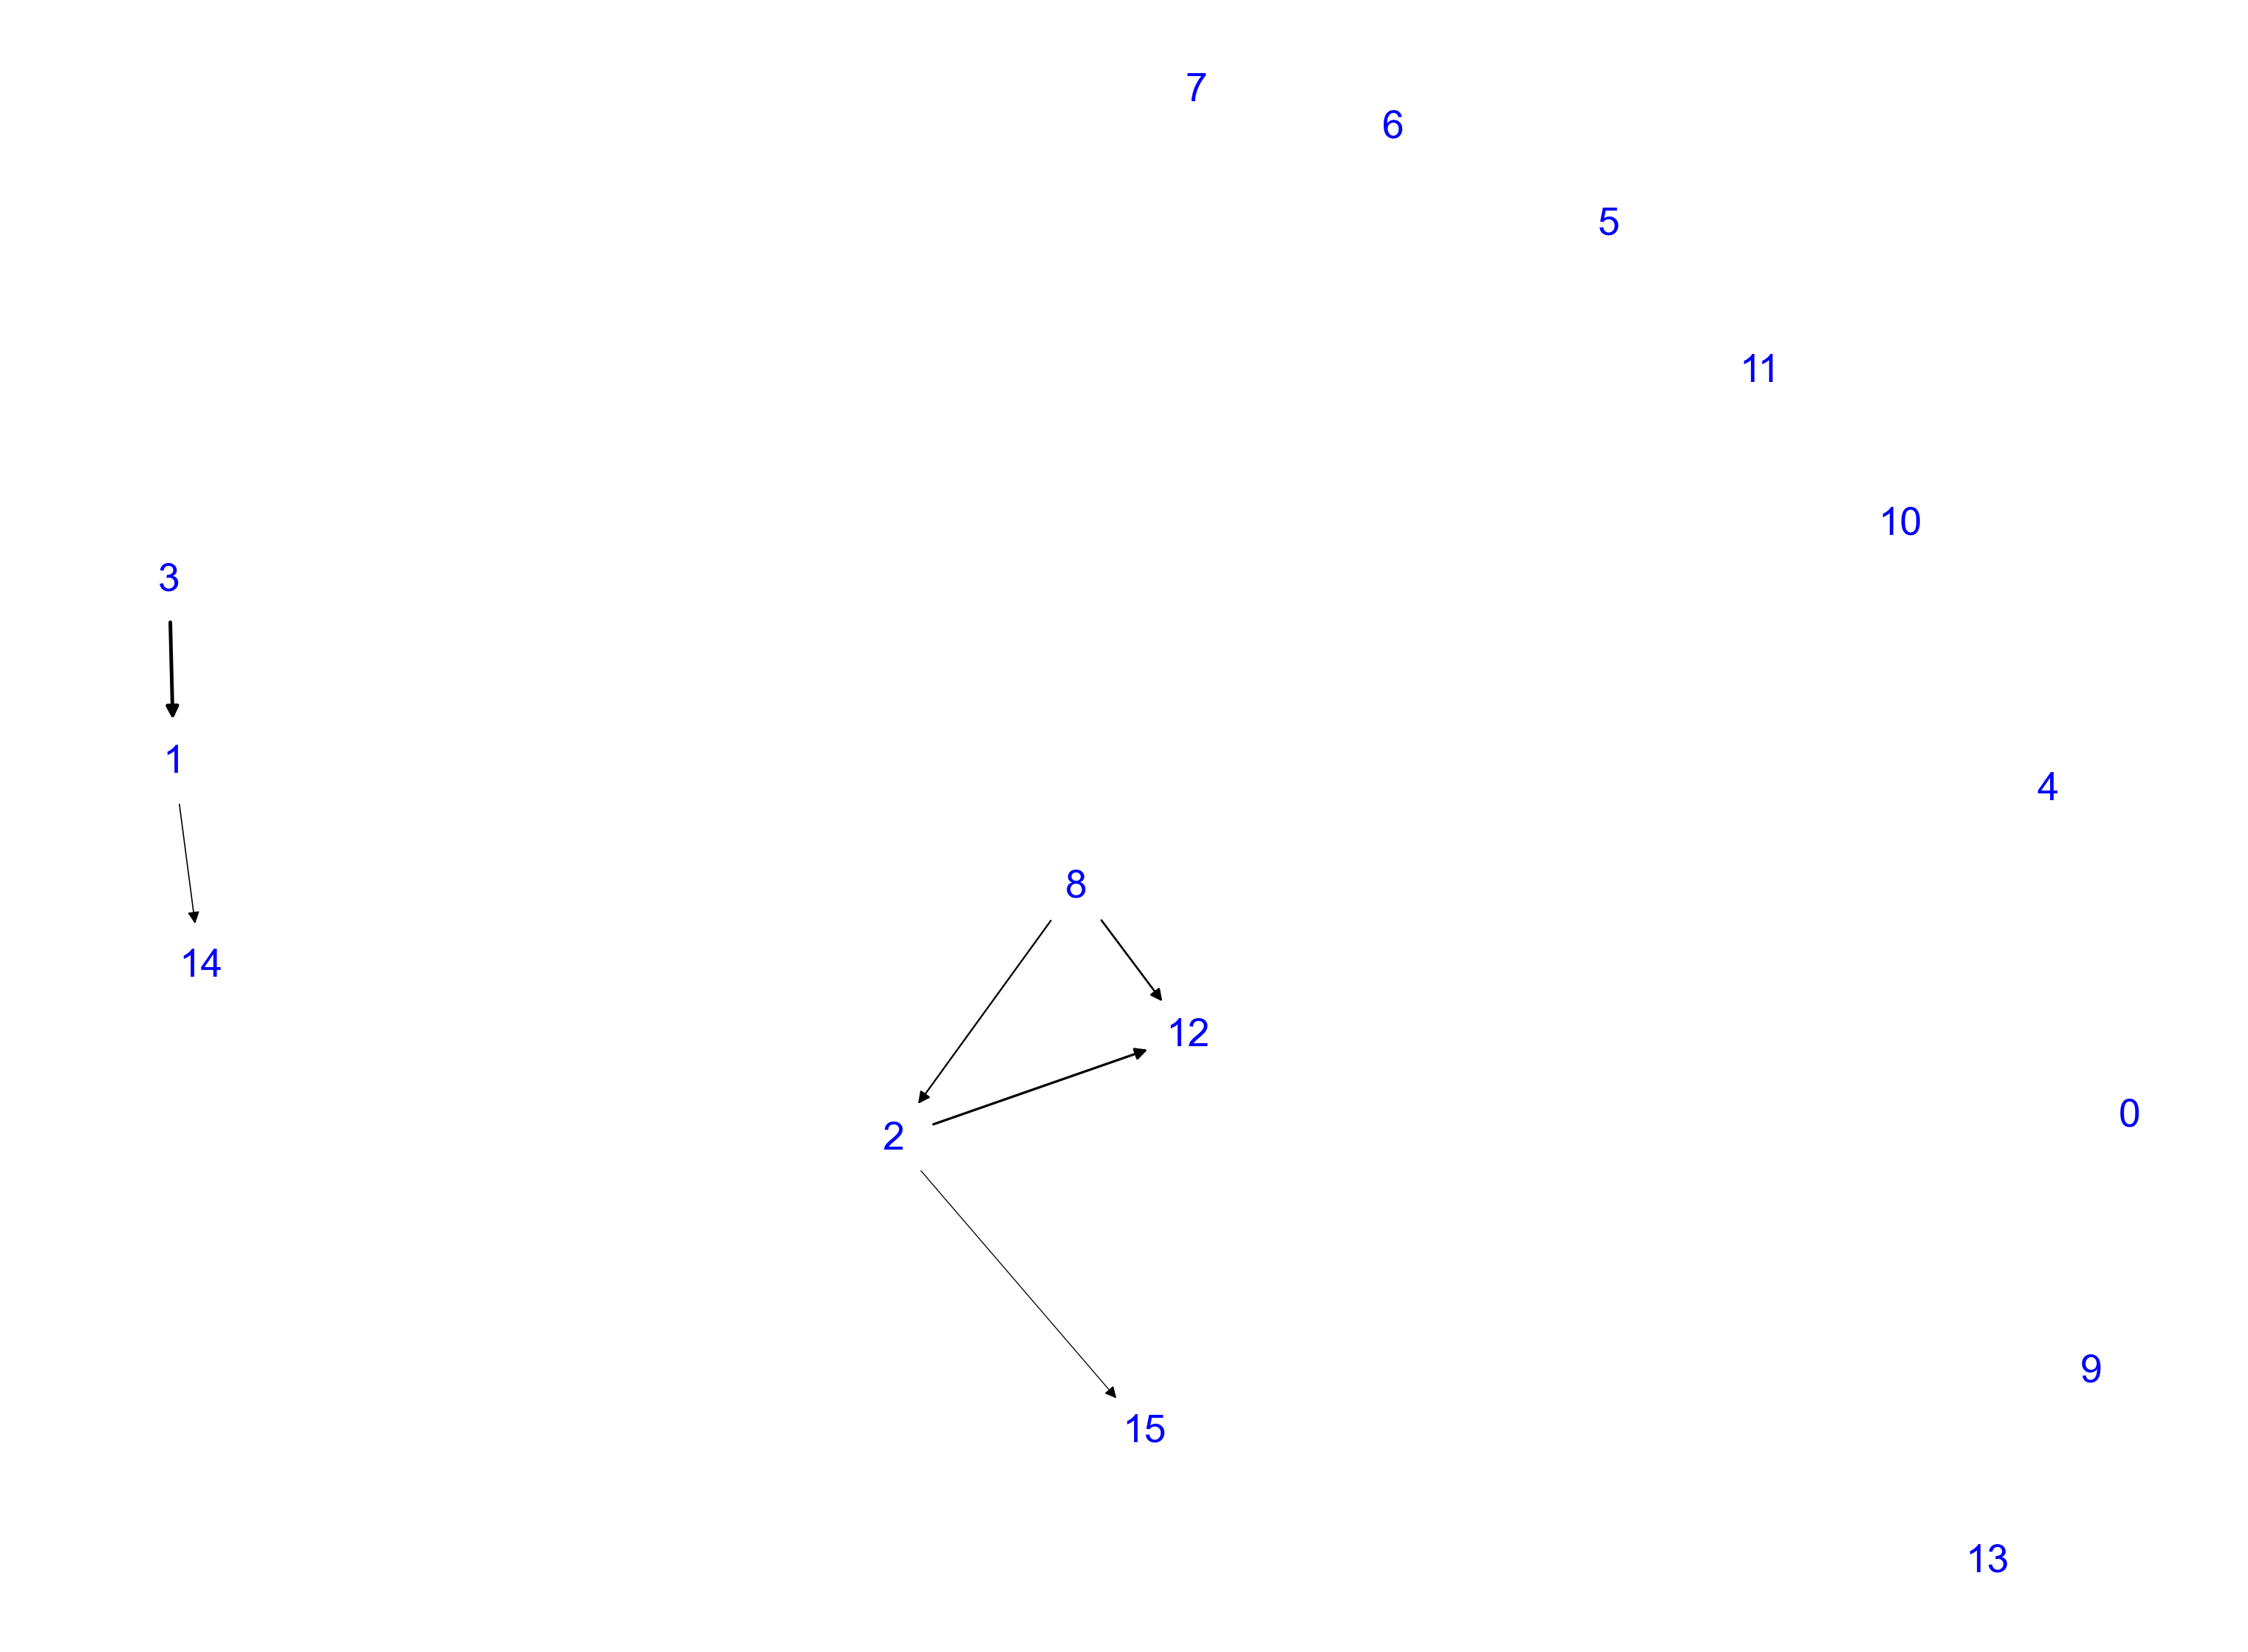

In [55]:
from utils.plot import plot_graph

g = nx.from_pandas_adjacency(G_directed_v2, create_using=nx.DiGraph)

print(g.nodes())

node_keys = list(node_positions.keys())  # Should be the same as g.nodes()
colors = [color_map[node] for node in node_keys if node in color_map]

plot_graph(
    g,
    node_positions=node_positions,
    figsize=(16, 12),
    offset=0.2,
    node_color=colors,
    font_size=16,
    font_color='blue',
    node_size=1200
)

In [56]:
print(g)

DiGraph with 16 nodes and 6 edges


In [57]:
from models.ti.downstream import (
    get_terminal_states,
    get_terminal_cells,
    sample_waypoints,
    compute_diff_potential,
)

In [58]:
X = preprocessed_data.obsm['metric_embedding']

n_neighbors = 50
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X)
adj_dist = nbrs.kneighbors_graph(X, mode="distance")
adj_conn = nbrs.kneighbors_graph(X)

In [59]:
# Terminal state computation

start_cell_ids = preprocessed_data.uns['start_id']
get_terminal_states(preprocessed_data, G_directed_v2, start_cell_ids, mad_multiplier=0.5)

Terminal cluster candidate 1: {0, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15}
Terminal cluster candidate 2: set()
Terminal clusters: {12, 14, 15}


{12, 14, 15}

In [60]:
# Ensure terminal states are computed before accessing terminal cells
if 'metric_terminal_clusters' not in preprocessed_data.uns:
	start_cell_ids = preprocessed_data.uns['start_id']
	get_terminal_states(preprocessed_data, G_directed_v2, start_cell_ids, mad_multiplier=0.5)

# Terminal cell computation
t_cell_ids = get_terminal_cells(preprocessed_data)
t_cell_ids

['FetalLiver_1.CACAAGCCAGACCACAAG',
 'Kidney_2.GGGTTTGGCTGCGAATTA',
 'FetalLiver_1.AGCGAGTAGCATTTAACT']

In [61]:
# Waypoint computation
from models.ti.downstream import sample_waypoints


dists, wp = sample_waypoints(preprocessed_data, adj_dist.todense(), n_waypoints=30)

/home/satwik/Desktop/presentation/models/ti/downstream.py:241: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dists.loc[cell_ids, k] = v
/home/satwik/Desktop/presentation/models/ti/downstream.py:241: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dists.loc[cell_ids, k] = v
/home/satwik/Desktop/presentation/models/ti/downstream.py:241: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

In [62]:
# Compute entropy and diff potential

ent, bps = compute_diff_potential(
    preprocessed_data,
    adj_dist.todense(),
    adj_cluster,
    std_factor=0,
    prune_wp_graph=True
)

Cell to Waypoint connectivity
Waypoint to Terminal State connectivity
Markov chain construction...
Computing fundamental matrix and absorption probabilities...


/home/satwik/dynooenv/lib/python3.12/site-packages/scipy/stats/_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


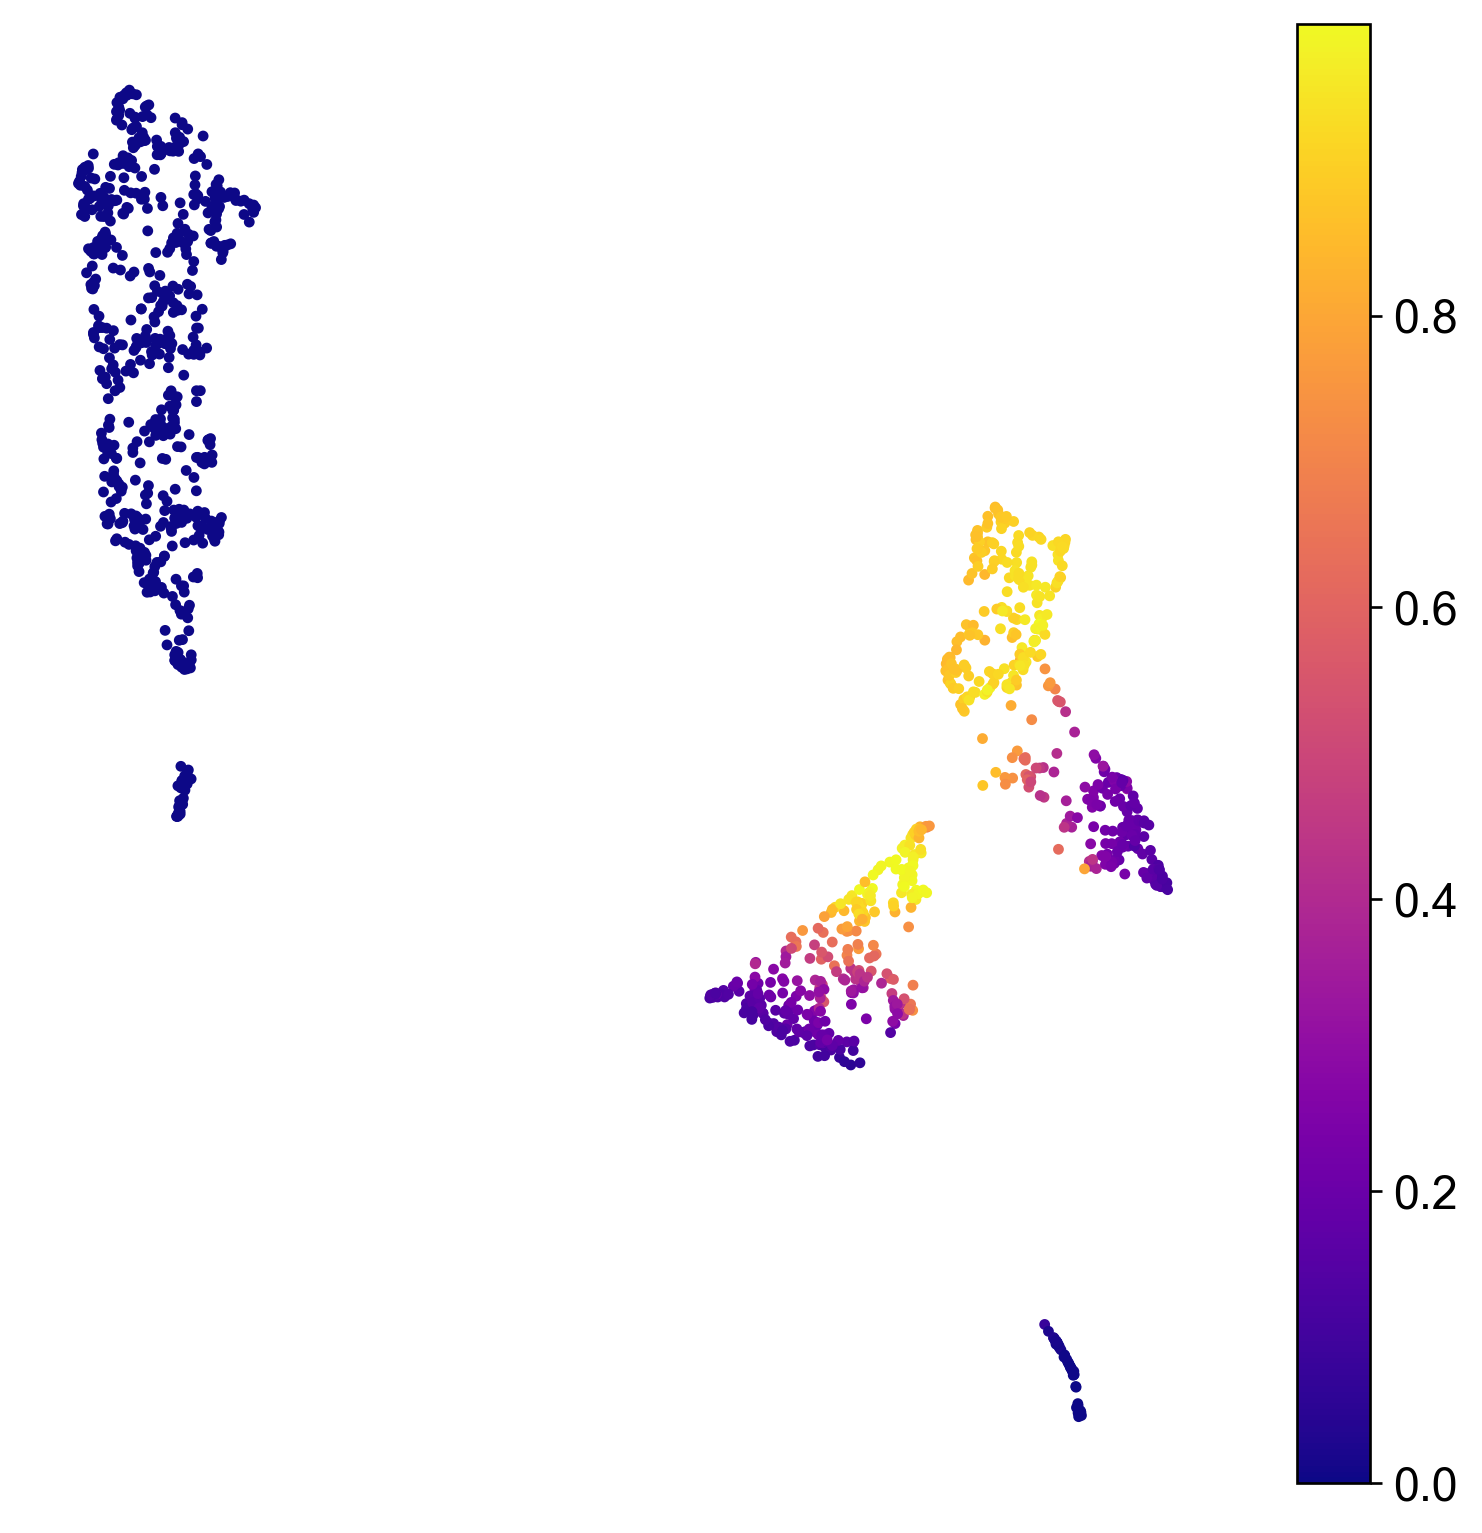

In [63]:
# Plot the Differentiation potential
plot_embeddings(
    preprocessed_data.obsm['X_met_embedding'],
    s=5,
    c=ent,
    figsize=(8, 8),
    cmap='plasma',
    show_colorbar=True
)

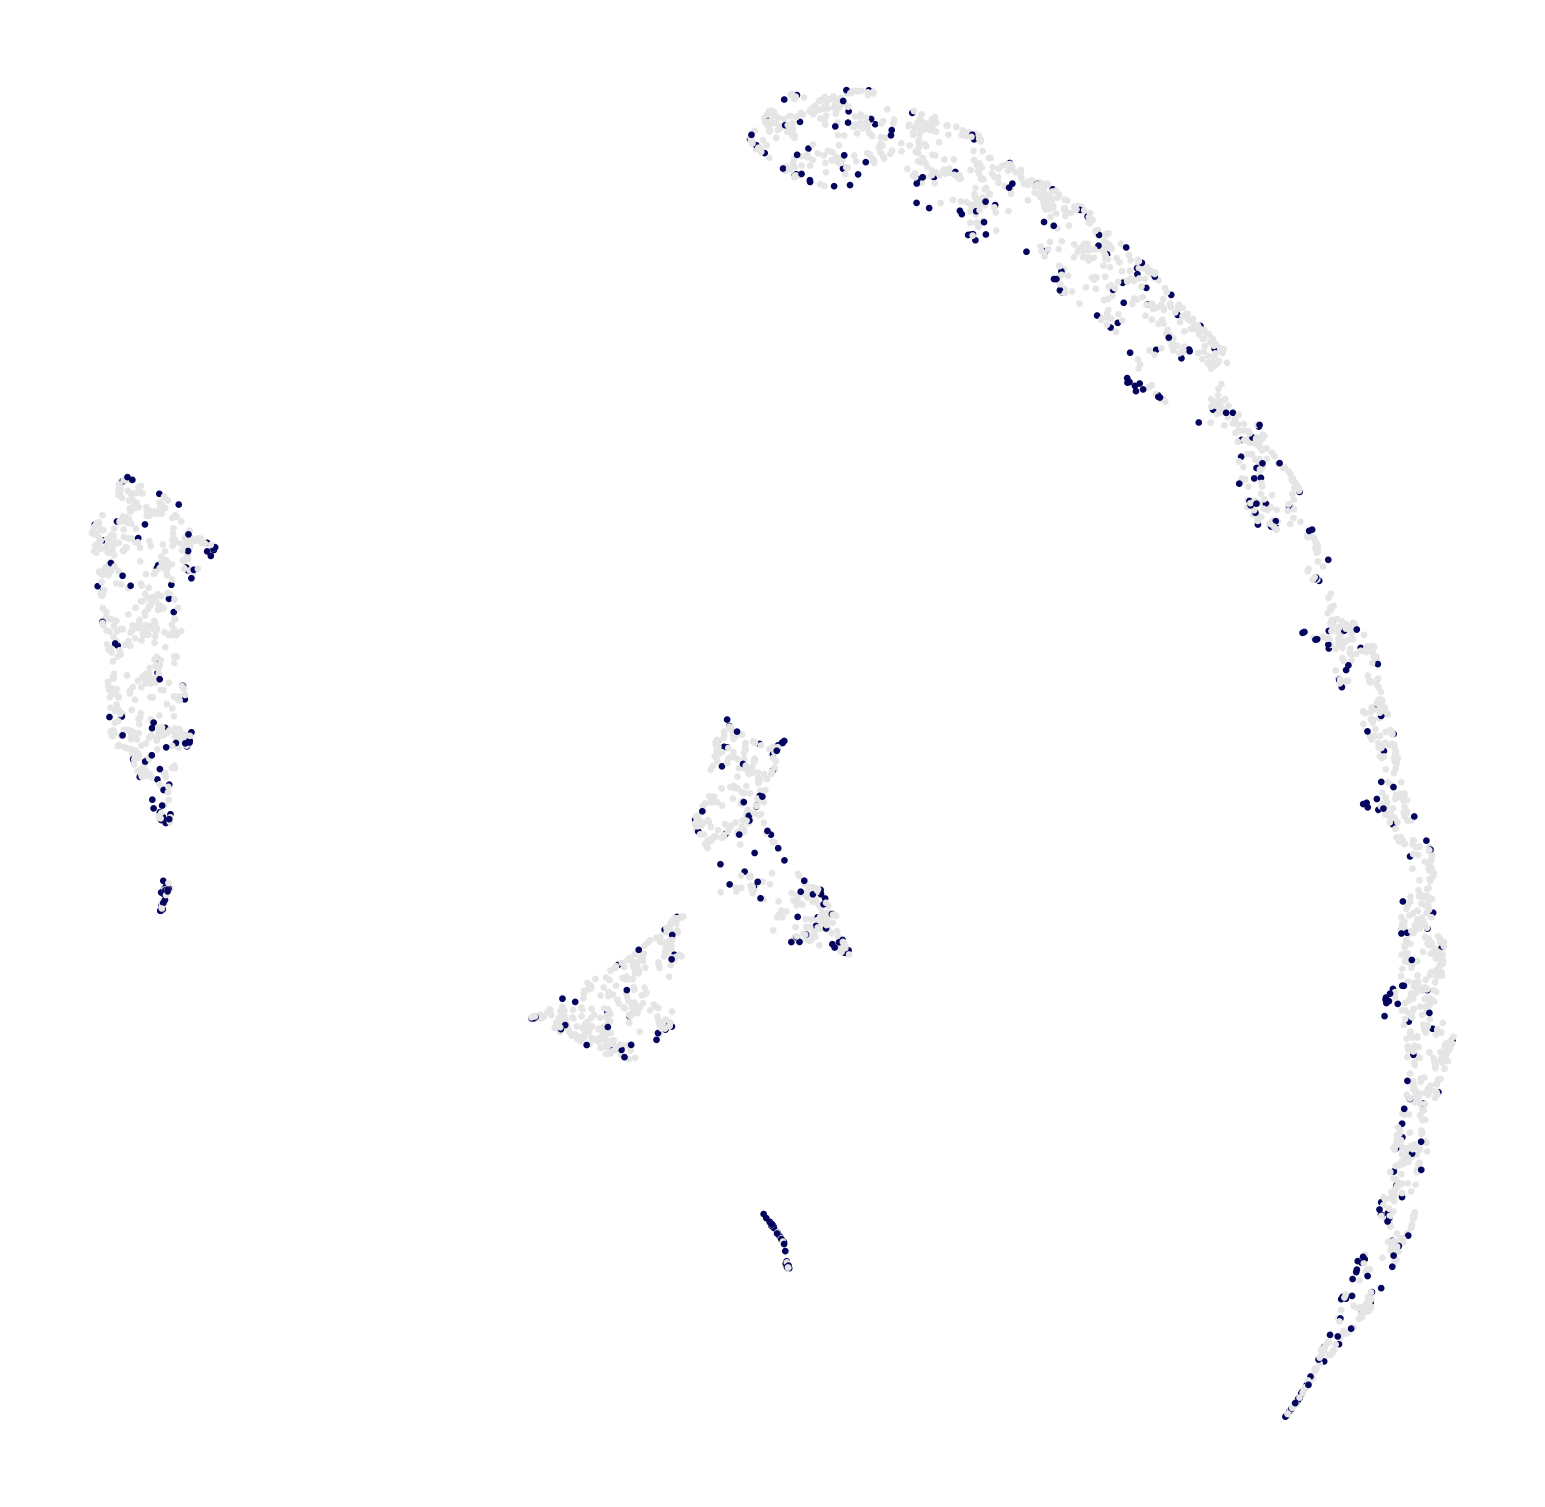

In [64]:
# Plot the sampled waypoints
colors = ['#03045E' if cell_id in preprocessed_data.uns['metric_waypoints'] else '#E5E5E5' for cell_id in preprocessed_data.obs_names]
plot_embeddings(
    preprocessed_data.obsm['X_met_embedding'],
    s=1,
    c=colors,
    figsize=(8, 8)
)

In [65]:
import scipy.stats as ss

ss.spearmanr(preprocessed_data.obs['metric_dp'], adata.uns['timecourse']['pt'])

SignificanceResult(statistic=nan, pvalue=nan)

# Margaret metrics

In [66]:
cell_ids = preprocessed_data.obs_names.tolist()
m_pseudotime = preprocessed_data.obs['metric_pseudotime_v2']
m_pseudotime.name = 'pseudotime'
m_milestone_ids = sorted(preprocessed_data.obs['metric_clusters'].unique())
m_milestone_ids = [str(i) for i in m_milestone_ids]
m_milestone_percentages = pd.DataFrame({'cell_id': cell_ids, 'milestone_id': list(preprocessed_data.obs['metric_clusters']), 'percentage': [1 for i in range(len(cell_ids))]})
m_milestone_percentages['milestone_id'] = m_milestone_percentages['milestone_id'].astype(str)
m_milestone_percentages

,cell_id,milestone_id,percentage
0,FetalLiver_1.AAGCGGGGGCGAATCTCT,7,1
1,FetalLiver_1.CTCGCAAGTTTATTCATA,7,1
2,FetalLiver_1.ACAATAGCCTAGTAGTCG,7,1
3,FetalLiver_1.CTCGCATACTTCTCAAAG,5,1
4,FetalLiver_1.AAGCGGATTCCAATTTGC,7,1
...,...,...,...
3206,Kidney_2.AAAACGGCCTAGGGGTTT,3,1
3207,Kidney_2.AACCTAAAAACGGTATAC,1,1
3208,Kidney_2.CTCCATGTTGCCCCGCTA,3,1
3209,Kidney_2.GACACTCCAGACCGCACC,1,1


In [67]:
G = nx.from_pandas_adjacency(G_directed_v2, create_using=nx.DiGraph)
m_edges_df = nx.to_pandas_edgelist(G).rename(columns={'source': 'from', 'target': 'to'})
m_edges_df['length'] = 1  # no weights stored, use default for now
m_edges_df['directed'] = True
m_edges_df['from'] = m_edges_df['from'].astype(str)
m_edges_df['to'] = m_edges_df['to'].astype(str)
del m_edges_df['weight']
m_edges_df

,from,to,length,directed
0,1,14,1,True
1,2,12,1,True
2,2,15,1,True
3,3,1,1,True
4,8,2,1,True
5,8,12,1,True


In [68]:
disconnected = set(m_milestone_ids)
for i in m_edges_df['from']:
    disconnected.discard(i)
for i in m_edges_df['to']:  
    disconnected.discard(i)
disconnected = list(disconnected)
new_rows = [{'from': i, 'to': i, 'length': 0, 'directed': True} for i in disconnected]
m_edges_df = pd.concat([m_edges_df, pd.DataFrame(new_rows)], ignore_index=True)
m_edges_df

,from,to,length,directed
0,1,14,1,True
1,2,12,1,True
2,2,15,1,True
3,3,1,1,True
4,8,2,1,True
5,8,12,1,True
6,7,7,0,True
7,10,10,0,True
8,9,9,0,True
9,6,6,0,True


In [69]:
m_milestone_percentages.percentage.value_counts()

percentage
1    3211
Name: count, dtype: int64

In [70]:
progressions = pd.DataFrame({
    'cell_id': cell_ids,
    'from': [1 for i in range(len(cell_ids))],
    'to': [1 for i in range(len(cell_ids))],
    'percentage': [1 for i in range(len(cell_ids))]
})
progressions

,cell_id,from,to,percentage
0,FetalLiver_1.AAGCGGGGGCGAATCTCT,1,1,1
1,FetalLiver_1.CTCGCAAGTTTATTCATA,1,1,1
2,FetalLiver_1.ACAATAGCCTAGTAGTCG,1,1,1
3,FetalLiver_1.CTCGCATACTTCTCAAAG,1,1,1
4,FetalLiver_1.AAGCGGATTCCAATTTGC,1,1,1
...,...,...,...,...
3206,Kidney_2.AAAACGGCCTAGGGGTTT,1,1,1
3207,Kidney_2.AACCTAAAAACGGTATAC,1,1,1
3208,Kidney_2.CTCCATGTTGCCCCGCTA,1,1,1
3209,Kidney_2.GACACTCCAGACCGCACC,1,1,1


In [71]:
cell_to_milestone = dict(zip(m_milestone_percentages['cell_id'], m_milestone_percentages['milestone_id']))
progressions['milestone'] = progressions['cell_id'].map(cell_to_milestone)
progressions

,cell_id,from,to,percentage,milestone
0,FetalLiver_1.AAGCGGGGGCGAATCTCT,1,1,1,7
1,FetalLiver_1.CTCGCAAGTTTATTCATA,1,1,1,7
2,FetalLiver_1.ACAATAGCCTAGTAGTCG,1,1,1,7
3,FetalLiver_1.CTCGCATACTTCTCAAAG,1,1,1,5
4,FetalLiver_1.AAGCGGATTCCAATTTGC,1,1,1,7
...,...,...,...,...,...
3206,Kidney_2.AAAACGGCCTAGGGGTTT,1,1,1,3
3207,Kidney_2.AACCTAAAAACGGTATAC,1,1,1,1
3208,Kidney_2.CTCCATGTTGCCCCGCTA,1,1,1,3
3209,Kidney_2.GACACTCCAGACCGCACC,1,1,1,1


In [72]:
import random

# Iterate through each row in the progressions DataFrame
for idx, row in progressions.iterrows():
    milestone = row['milestone']
    
    # Filter rows in the milestone_network (m_edges_df) where the milestone is in 'from' or 'to'
    matching_rows = m_edges_df[(m_edges_df['from'] == milestone) | (m_edges_df['to'] == milestone)]
    
    # Pick one row at random from the matching rows
    selected_row = matching_rows.sample(n=1).iloc[0]
    
    # Update the 'from' and 'to' columns in progressions
    progressions.at[idx, 'from'] = selected_row['from']
    progressions.at[idx, 'to'] = selected_row['to']
    
    # Update the 'percentage' column based on whether the milestone was in 'from' or 'to'
    if selected_row['from'] == milestone:
        progressions.at[idx, 'percentage'] = 0
    elif selected_row['to'] == milestone:
        progressions.at[idx, 'percentage'] = 1

progressions

,cell_id,from,to,percentage,milestone
0,FetalLiver_1.AAGCGGGGGCGAATCTCT,7,7,0,7
1,FetalLiver_1.CTCGCAAGTTTATTCATA,7,7,0,7
2,FetalLiver_1.ACAATAGCCTAGTAGTCG,7,7,0,7
3,FetalLiver_1.CTCGCATACTTCTCAAAG,5,5,0,5
4,FetalLiver_1.AAGCGGATTCCAATTTGC,7,7,0,7
...,...,...,...,...,...
3206,Kidney_2.AAAACGGCCTAGGGGTTT,3,1,0,3
3207,Kidney_2.AACCTAAAAACGGTATAC,3,1,1,1
3208,Kidney_2.CTCCATGTTGCCCCGCTA,3,1,0,3
3209,Kidney_2.GACACTCCAGACCGCACC,3,1,1,1


In [73]:
progressions.percentage.value_counts()

percentage
0    2678
1     533
Name: count, dtype: int64

In [74]:
del progressions['milestone']

In [75]:
%%R -i cell_ids -i m_pseudotime -i m_milestone_ids -i m_milestone_percentages -i m_edges_df -i progressions

m_dataset <- readRDS("mouse-cell-atlas-combination-2.rds")

marg_traj <- add_trajectory(
    m_dataset,
    cell_ids = cell_ids,
    pseudotime = m_pseudotime,
    milestone_ids = m_milestone_ids,
    milestone_percentages = m_milestone_percentages,
    allow_self_loops = TRUE,
    milestone_network = m_edges_df,
    progressions = progressions
)

In addition: Warning message:
In add_trajectory(m_dataset, cell_ids = cell_ids, pseudotime = m_pseudotime,  :
  Both milestone_percentages and progressions are given, will only use progressions


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


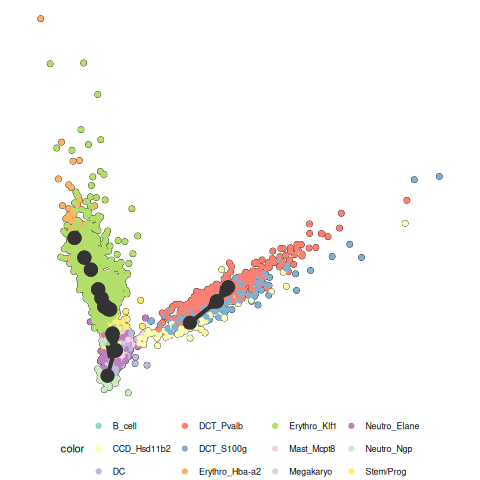

In [76]:
%%R
plot_dimred(marg_traj, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

In [80]:
%%R
marg_traj$milestone_network <- marg_traj$milestone_network[marg_traj$milestone_network$length != 0, ]
marg_traj$milestone_network

  from to length directed
0    1 14      1     TRUE
1    2 12      1     TRUE
2    2 15      1     TRUE
3    3  1      1     TRUE
4    8  2      1     TRUE
5    8 12      1     TRUE


In [81]:
%%R
marg_metrics <- calculate_metrics(
  dataset = m_dataset,
  model = marg_traj,
  metrics = dyneval::metrics$metric_id,
  expression_source = m_dataset$expression
)

In [82]:
%%R
cat("HIM =", marg_metrics$him, "\n")
cat("F1_branches =", marg_metrics$F1_branches, "\n")
cat("correlation =", marg_metrics$correlation, "\n")
cat("featureimp_wcor =", marg_metrics$featureimp_wcor, "\n")
m_selected_metrics <- c(
  him = as.numeric(marg_metrics$him),
  F1_branches = marg_metrics$F1_branches,
  correlation = marg_metrics$correlation,
  featureimp_wcor = marg_metrics$featureimp_wcor
)
m_overall_score <- exp(mean(log(m_selected_metrics)))
cat("overall_score =", m_overall_score, "\n")

HIM = 0.471205 
F1_branches = 0.3691352 
correlation = 0.5286307 
featureimp_wcor = 0.8860141 
overall_score = 0.5342532 


# Palantir

In [83]:
import scanpy as sc
import palantir

%matplotlib inline

In [84]:
ad = adata.copy()
# sc.pp.normalize_per_cell(ad)

# from utils.util import log_transform

# log_transform(ad, pseudo_count=0.1)
# sc.pp.highly_variable_genes(ad, n_top_genes=1500, flavor='cell_ranger')
pca_projections, _ = palantir.utils.run_pca(ad, use_hvg=False)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=10)
ms_data = palantir.utils.determine_multiscale_space(dm_res)

In [85]:
from utils.plot import generate_plot_embeddings, plot_embeddings

In [86]:
X_dm = generate_plot_embeddings(ms_data, perplexity=150, method='tsne', random_state=0)

Runtime for generate_plot_embeddings(): 16.847938776016235


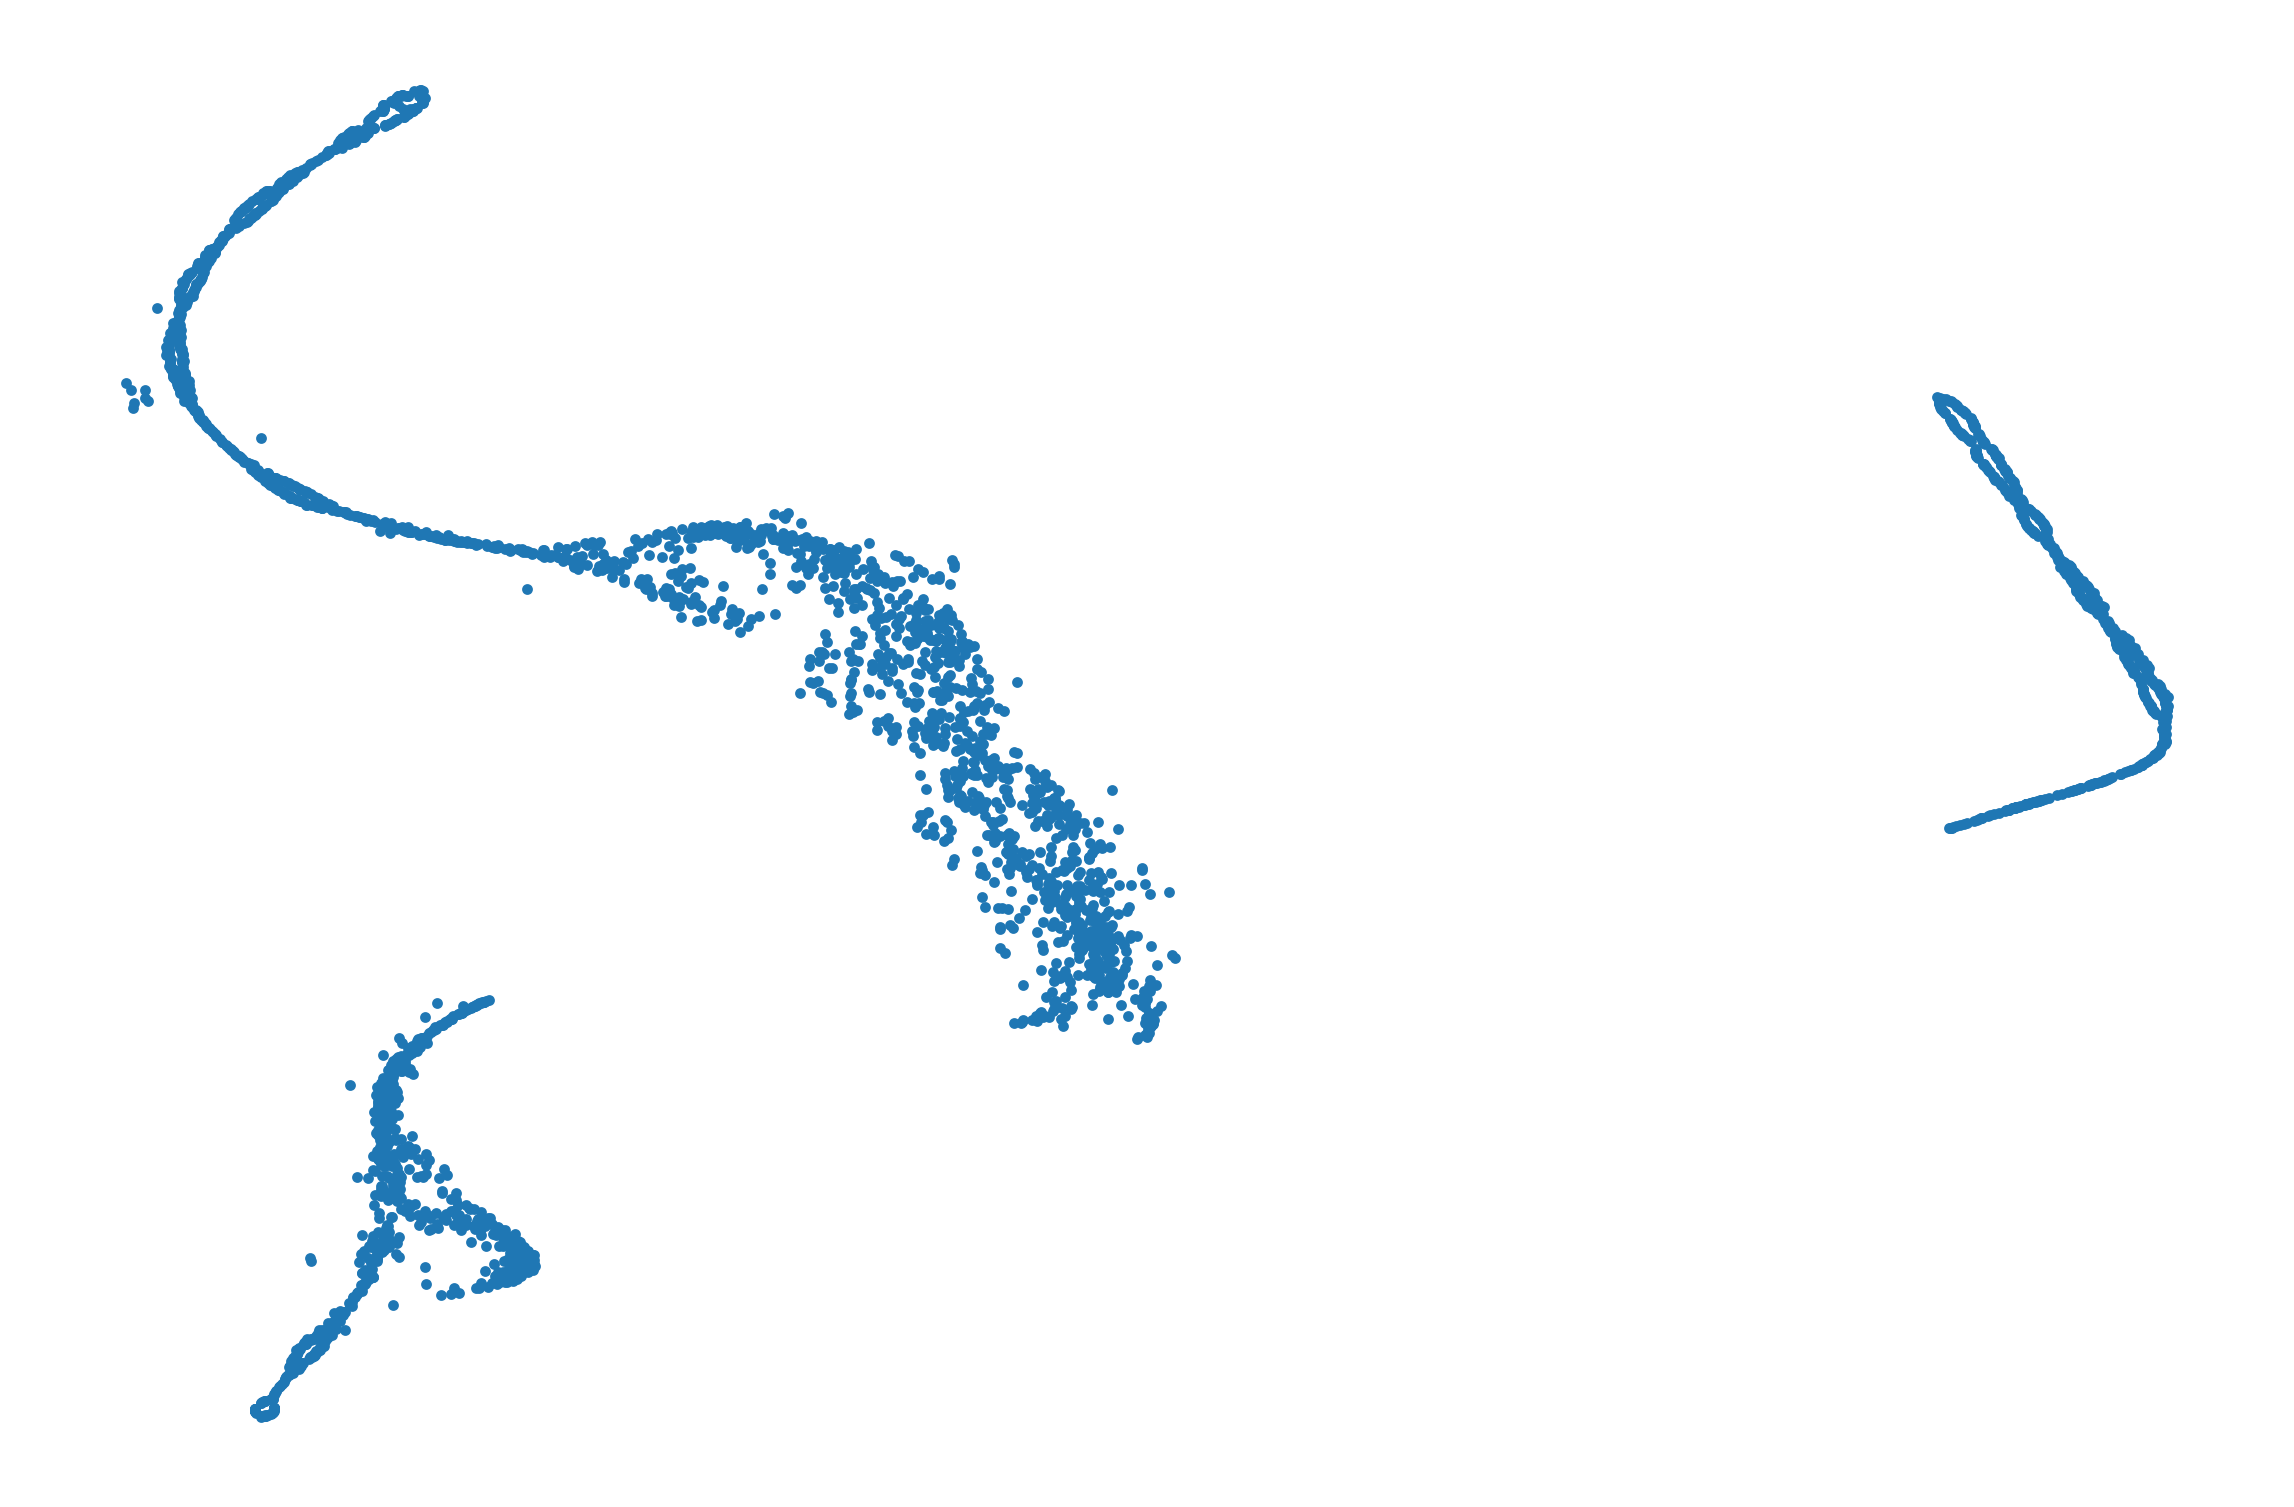

In [87]:
plot_embeddings(X_dm, s=5)

In [88]:
ad.uns['start_id']

array(['Kidney_2.AGCGAGATGCTTAACCTA', 'FetalLiver_1.TTTAGGCGTGGCCCGACG'],
      dtype=object)

In [89]:
early_cell = ad.uns['start_id'][0]
# early_cell = ad.uns['start_id'][1]
presults = palantir.core.run_palantir(ms_data, early_cell)

Sampling and flocking waypoints...
Time for determining waypoints: 0.00839606523513794 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.5394762396812439 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


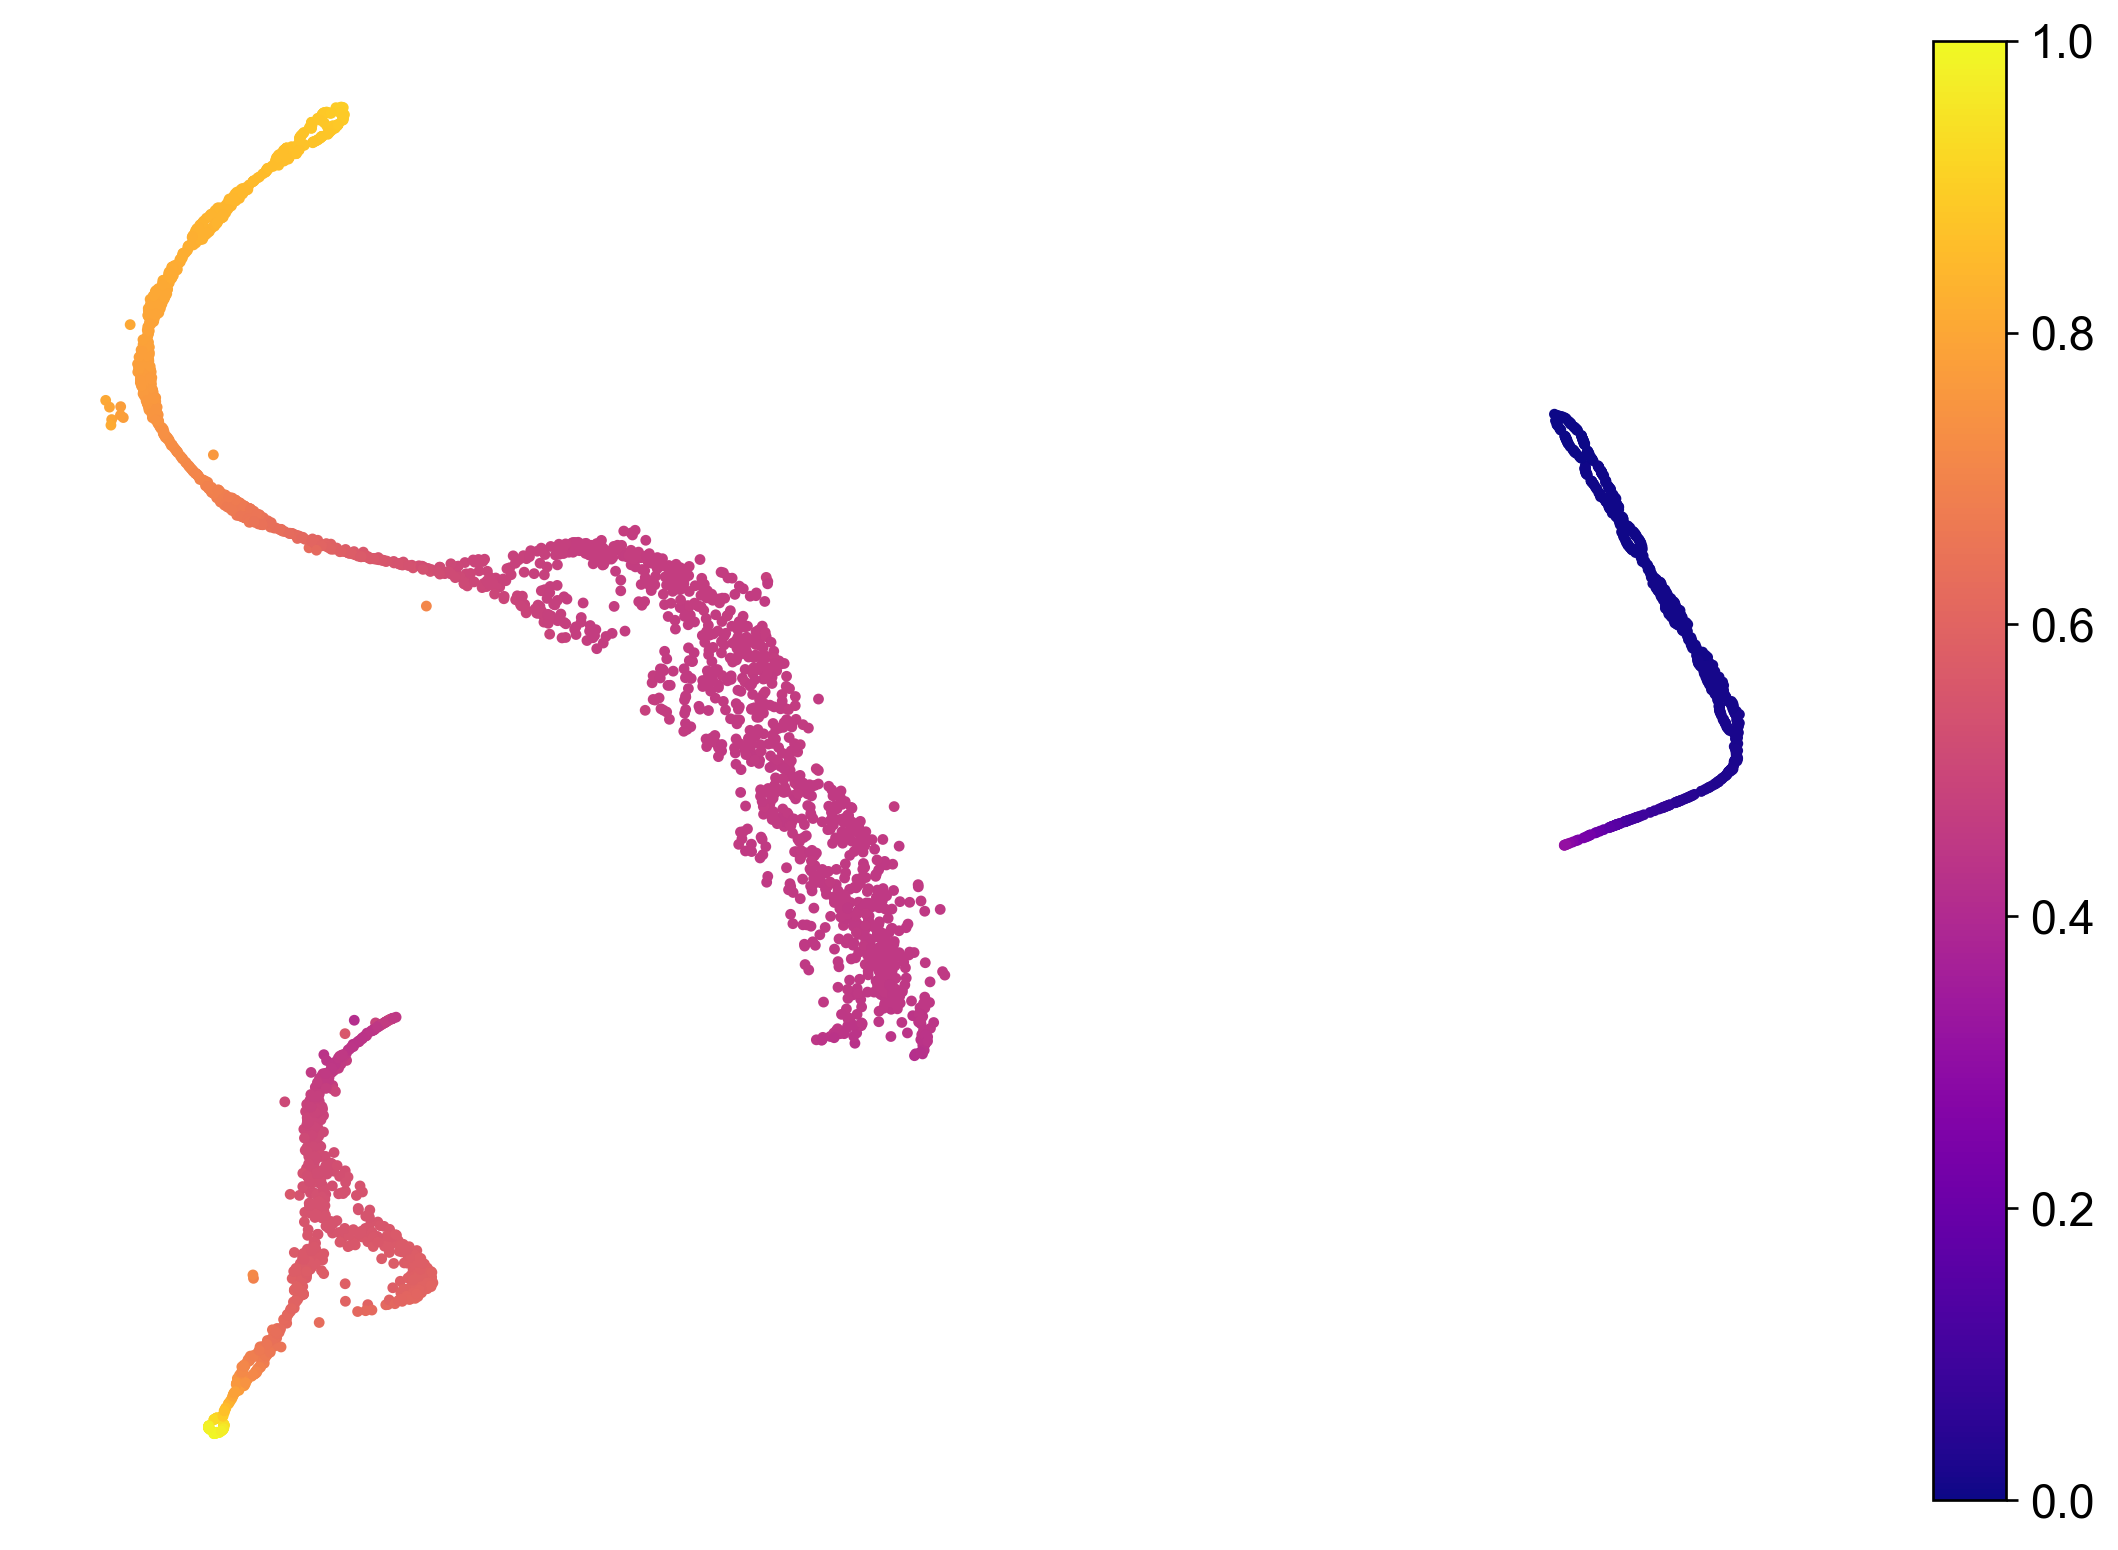

In [90]:
plot_embeddings(
    X_dm,
    s=5,
    c=presults.pseudotime,
    cmap='plasma',
    show_colorbar=True
)

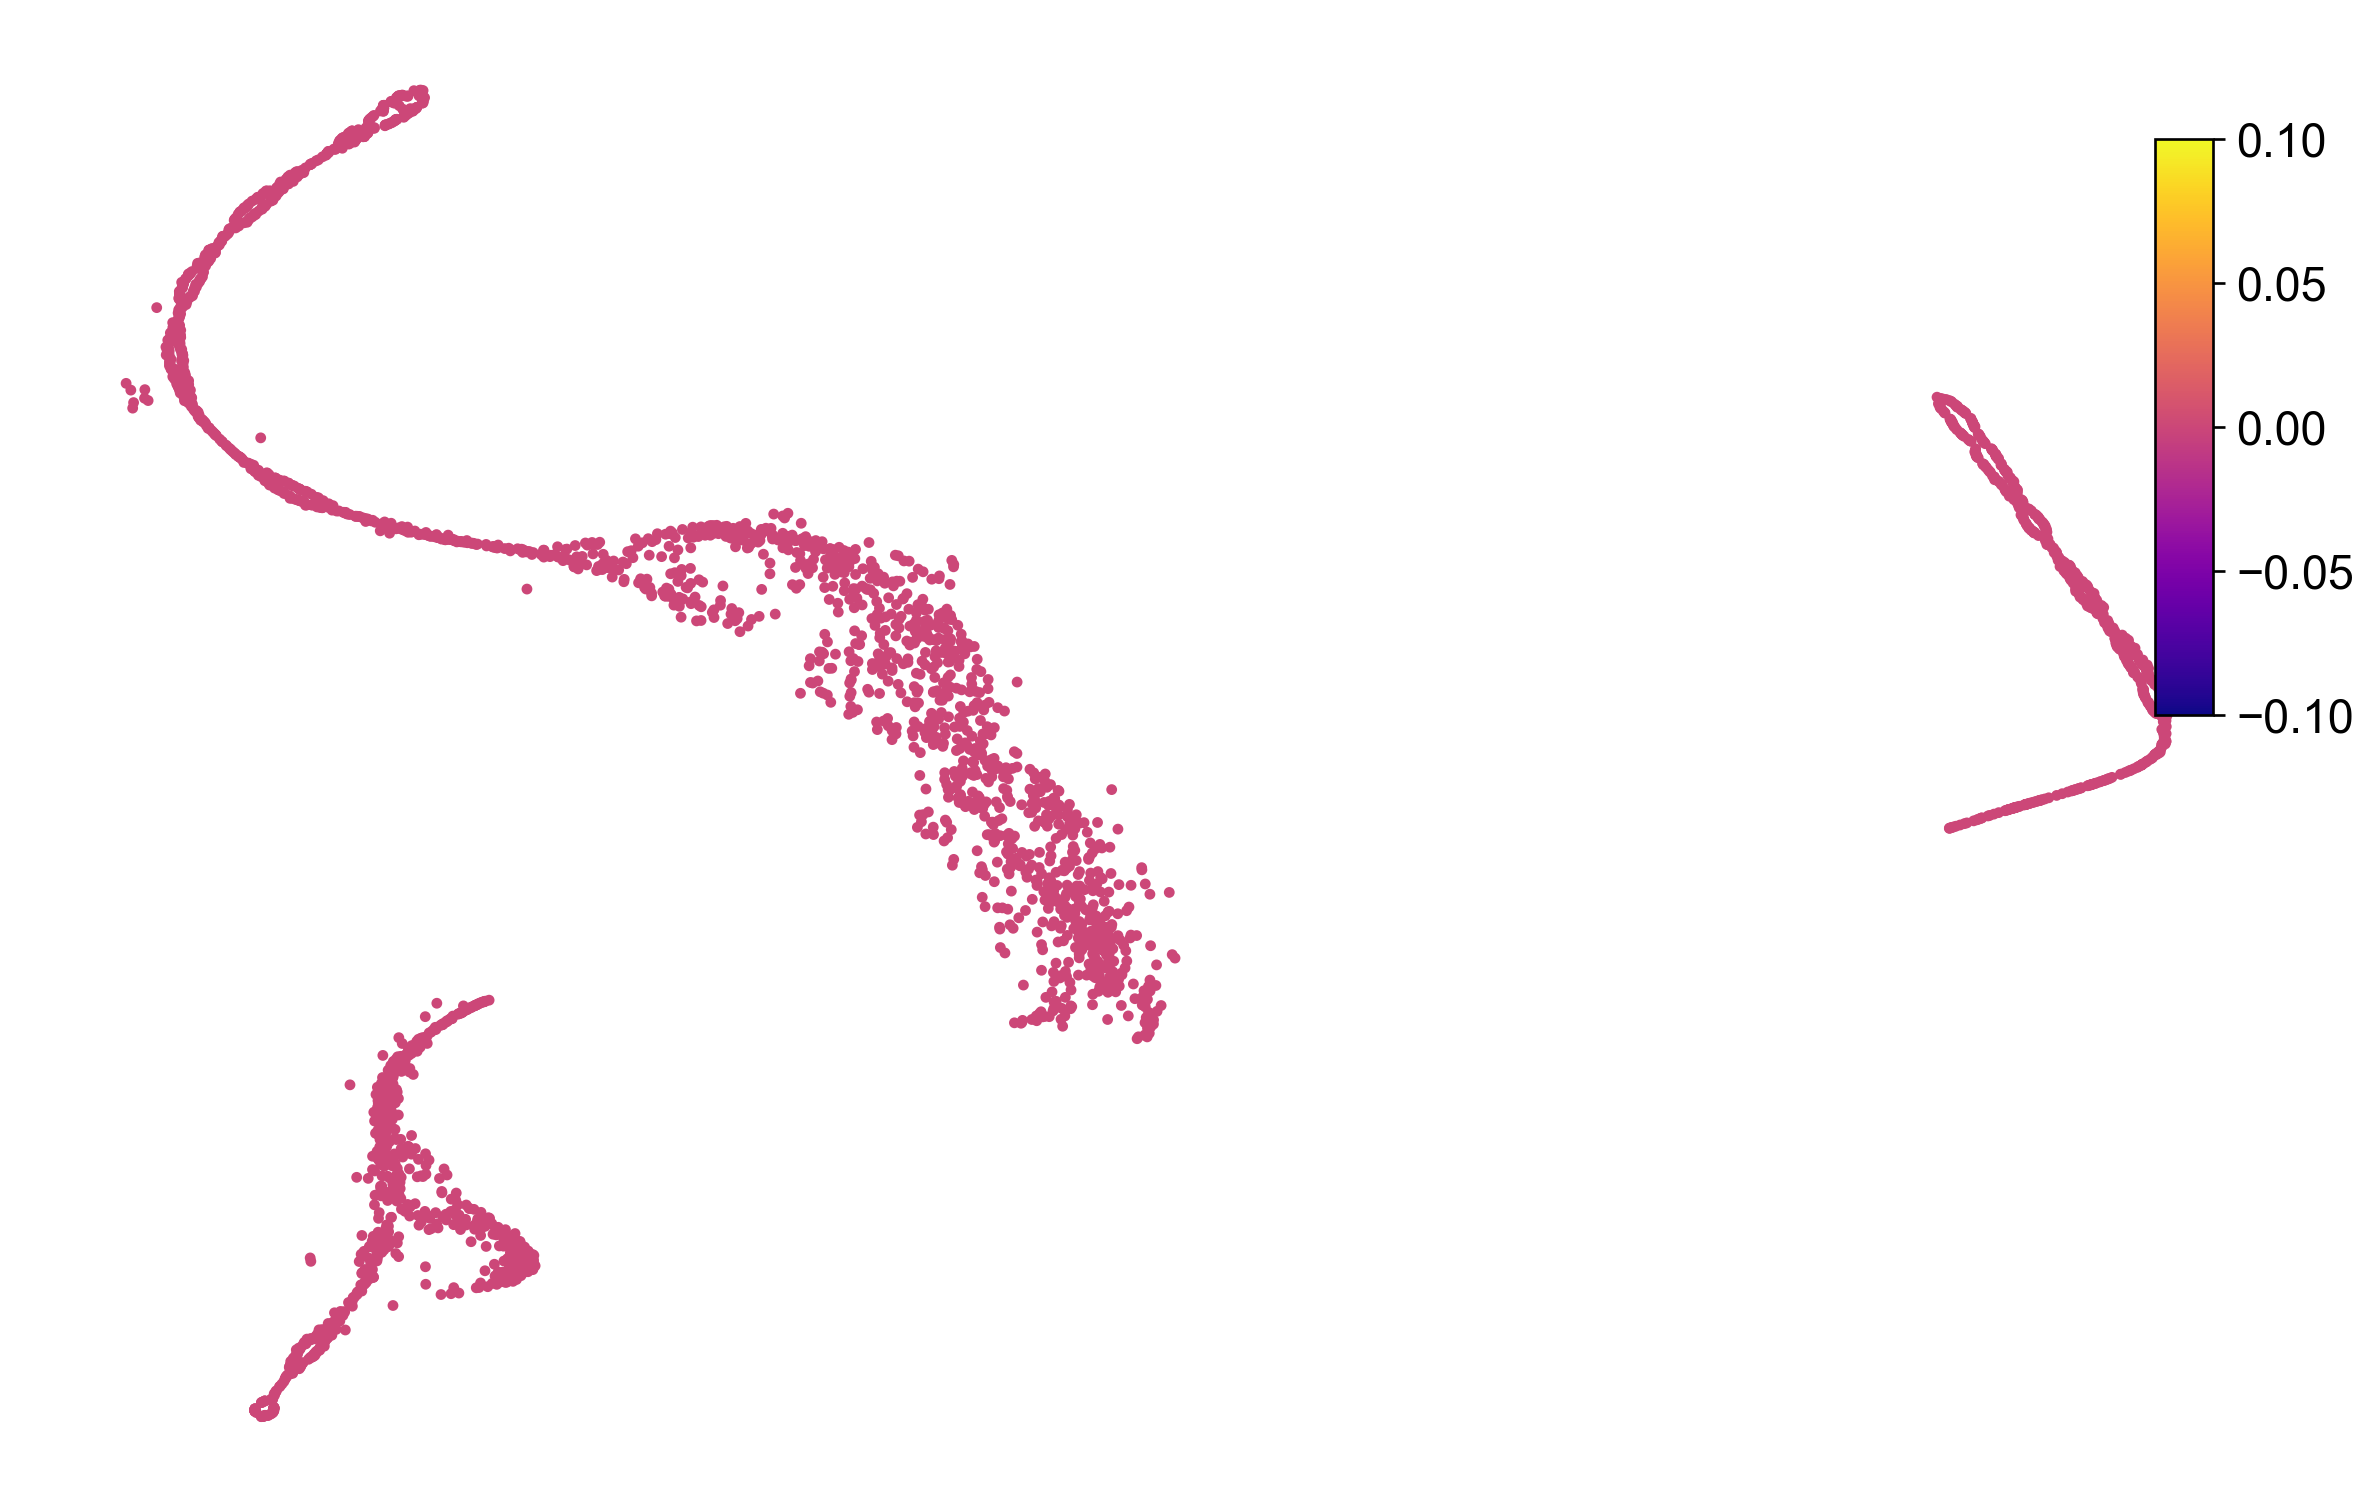

In [91]:
plot_embeddings(
    X_dm,
    s=5,
    c=presults.entropy,
    cmap='plasma',
    show_colorbar=True,
    cb_axes_pos=[0.92, 0.55, 0.02, 0.3]
)

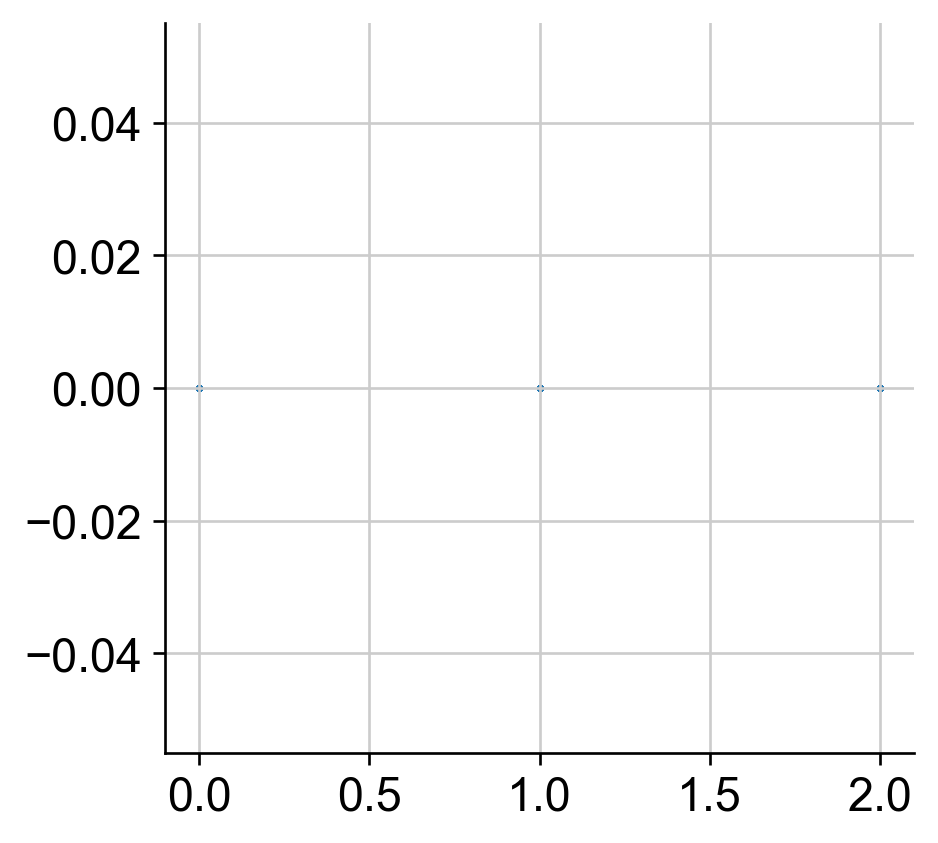

In [92]:
plt.scatter(adata.uns['timecourse']['pt'], presults.entropy, s=1)
# Remove the right and top axes
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

In [93]:
import scipy.stats as ss

ss.spearmanr(presults.entropy, adata.uns['timecourse']['pt'])

/home/satwik/dynooenv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


SignificanceResult(statistic=nan, pvalue=nan)

# Palantir metrics

In [94]:
pal_pseudotime = presults.pseudotime
pal_branch_probs = presults.branch_probs
pal_branch_probs

""
FetalLiver_1.AAGCGGGGGCGAATCTCT
FetalLiver_1.CTCGCAAGTTTATTCATA
FetalLiver_1.ACAATAGCCTAGTAGTCG
FetalLiver_1.CTCGCATACTTCTCAAAG
FetalLiver_1.AAGCGGATTCCAATTTGC
...
Kidney_2.AAAACGGCCTAGGGGTTT
Kidney_2.AACCTAAAAACGGTATAC
Kidney_2.CTCCATGTTGCCCCGCTA
Kidney_2.GACACTCCAGACCGCACC


In [95]:
pal_branch_probs.reset_index(inplace=True)
pal_branch_probs.rename(columns={'index': 'cell_id'}, inplace=True)
pal_branch_probs

,cell_id
0,FetalLiver_1.AAGCGGGGGCGAATCTCT
1,FetalLiver_1.CTCGCAAGTTTATTCATA
2,FetalLiver_1.ACAATAGCCTAGTAGTCG
3,FetalLiver_1.CTCGCATACTTCTCAAAG
4,FetalLiver_1.AAGCGGATTCCAATTTGC
...,...
3206,Kidney_2.AAAACGGCCTAGGGGTTT
3207,Kidney_2.AACCTAAAAACGGTATAC
3208,Kidney_2.CTCCATGTTGCCCCGCTA
3209,Kidney_2.GACACTCCAGACCGCACC


In [96]:
%%R -i pal_pseudotime -i pal_branch_probs
pal_dataset <- readRDS("mouse-cell-atlas-combination-2.rds")
pal_traj <- add_end_state_probabilities(
  pal_dataset,
  end_state_probabilities = pal_branch_probs,
  pseudotime = pal_pseudotime,
)

In [97]:
%%R
pal_metrics <- calculate_metrics(
  dataset = pal_dataset,
  model = pal_traj,
  metrics = c('rf_mse', 'rf_nmse', 'rf_rsq', 'lm_nmse', 'lm_mse', 'lm_rsq', 'edge_flip', 'him', 'isomorphic', 'featureimp_cor', 'featureimp_wcor', 'featureimp_ks', 'featureimp_wilcox', 'F1_branches', 'F1_milestones', 'harm_mean', 'geom_mean', 'arith_mean'),
  expression_source = pal_dataset$expression
)

In [98]:
%%R
cat("HIM =", pal_metrics$him, "\n")
cat("F1_branches =", pal_metrics$F1_branches, "\n")
# cat("correlation =", pal_metrics$correlation, "\n")
cat("featureimp_wcor =", pal_metrics$featureimp_wcor, "\n")
pal_selected_metrics <- c(
  him = as.numeric(pal_metrics$him),
  F1_branches = pal_metrics$F1_branches,
  # correlation = pal_metrics$correlation,
  featureimp_wcor = pal_metrics$featureimp_wcor
)
pal_overall_score <- exp(mean(log(pal_selected_metrics)))
cat("overall_score =", pal_overall_score, "\n")

HIM = 0.2715863 
F1_branches = 0.2287983 
featureimp_wcor = 0.8865188 
overall_score = 0.3804955 


In [ ]:
%%R
# plot_dimred(pal_traj, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

NULL


# paga

In [77]:
import scanpy as sc

In [78]:
# data_path = '/content/drive/MyDrive/project_margaret/simulated/multifurcating/dyntoy_multifurcating_gen_5.h5ad'
# ad = sc.read(data_path)
ad = adata.copy()

In [79]:
# from utils.util import preprocess_recipe

# # Preprocessing using Seurat default parameters
# min_expr_level = 3
# min_cells = None
# use_hvg = False
# n_top_genes = 720
# preprocessed_data = preprocess_recipe(
#     ad,
#     min_expr_level=min_expr_level,
#     min_cells=min_cells,
#     use_hvg=use_hvg,
#     n_top_genes=n_top_genes,
#     scale=True
# )

In [80]:
from utils.util import run_pca

# Apply PCA on the raw data for initial denoising
print('Computing PCA...')
X_pca, _, n_comps = run_pca(preprocessed_data, use_hvg=False, n_components=50)
preprocessed_data.obsm['X_pca'] = X_pca
print(f'Components computed: {n_comps}')

Computing PCA...
Runtime for run_pca(): 1.3086671829223633
Components computed: 50


In [81]:
sc.pp.neighbors(preprocessed_data, n_neighbors=15)

In [82]:
sc.tl.umap(preprocessed_data, n_components=2, min_dist=0.1)

In [83]:
sc.pp.neighbors(preprocessed_data, n_neighbors=20, use_rep='X_umap', key_added='knn_umap')

In [84]:
sc.tl.leiden(preprocessed_data, random_state=0, resolution=1.0, neighbors_key='knn_umap')

/tmp/ipykernel_967544/2546193246.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(preprocessed_data, random_state=0, resolution=1.0, neighbors_key='knn_umap')


In [85]:
sc.tl.paga(preprocessed_data, neighbors_key='knn_umap')

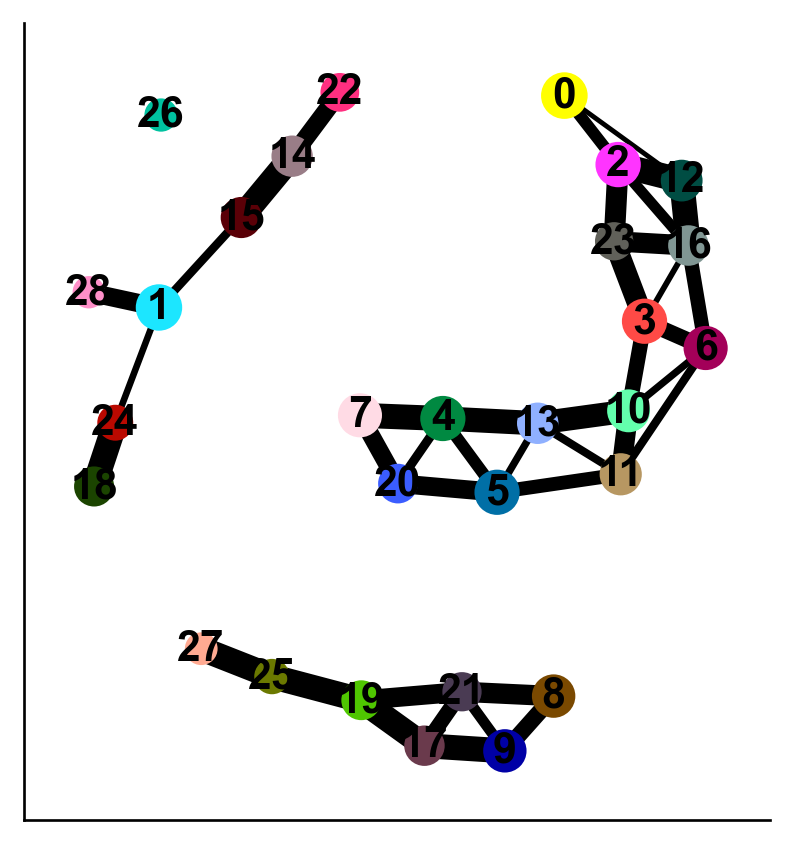

In [86]:
sc.pl.paga(preprocessed_data, save='mono3_d4.png')

In [87]:
import networkx as nx
from models.ti.graph import compute_gt_milestone_network

paga_conns = np.array(preprocessed_data.uns['paga']['connectivities'].todense())
paga_conns_filtered = (paga_conns > 0.05).astype(int)
g = nx.from_numpy_array(paga_conns_filtered)
gt = compute_gt_milestone_network(preprocessed_data, mode='undirected')

Runtime for compute_gt_milestone_network(): 0.0007810592651367188


In [88]:
from metrics.ipsen import IpsenMikhailov

im = IpsenMikhailov()
dist = im(g, gt)
print(dist)

0.7462135314829531


# Paga metrics

In [89]:
%%R
paga_dataset <- readRDS("mouse-cell-atlas-combination-2.rds")

In [90]:
cell_ids = preprocessed_data.obs_names.to_list()
paga_milestone_ids = list(g.nodes())
for i in range(len(paga_milestone_ids)):
    paga_milestone_ids[i] = str(paga_milestone_ids[i])
paga_milestone_percentages = pd.DataFrame({'cell_id': cell_ids, 'milestone_id': list(preprocessed_data.obs["leiden"].astype(str)), 'percentage': [1 for i in range(len(cell_ids))]})
paga_milestone_percentages

,cell_id,milestone_id,percentage
0,FetalLiver_1.AAGCGGGGGCGAATCTCT,7,1
1,FetalLiver_1.CTCGCAAGTTTATTCATA,7,1
2,FetalLiver_1.ACAATAGCCTAGTAGTCG,7,1
3,FetalLiver_1.CTCGCATACTTCTCAAAG,13,1
4,FetalLiver_1.AAGCGGATTCCAATTTGC,7,1
...,...,...,...
3206,Kidney_2.AAAACGGCCTAGGGGTTT,8,1
3207,Kidney_2.AACCTAAAAACGGTATAC,21,1
3208,Kidney_2.CTCCATGTTGCCCCGCTA,8,1
3209,Kidney_2.GACACTCCAGACCGCACC,8,1


In [91]:
fromlist = []
tolist = []
for t in g.edges:
    fromlist.append(str(t[0]))
    tolist.append(str(t[1]))
paga_edges_df = pd.DataFrame({'from': fromlist, 'to': tolist, 'length': 1, 'directed': False})
paga_edges_df

,from,to,length,directed
0,0,2,1,False
1,0,12,1,False
2,1,15,1,False
3,1,24,1,False
4,1,28,1,False
5,2,12,1,False
6,2,16,1,False
7,2,23,1,False
8,3,6,1,False
9,3,10,1,False


In [92]:
disconnected = set(paga_milestone_ids)
for i in paga_edges_df['from']:
    disconnected.discard(i)
for i in paga_edges_df['to']:  
    disconnected.discard(i)
disconnected = list(disconnected)
new_rows = [{'from': i, 'to': i, 'length': 0, 'directed': True} for i in disconnected]
paga_edges_df = pd.concat([paga_edges_df, pd.DataFrame(new_rows)], ignore_index=True)
paga_edges_df

,from,to,length,directed
0,0,2,1,False
1,0,12,1,False
2,1,15,1,False
3,1,24,1,False
4,1,28,1,False
5,2,12,1,False
6,2,16,1,False
7,2,23,1,False
8,3,6,1,False
9,3,10,1,False


In [93]:
paga_progressions = pd.DataFrame({
    'cell_id': cell_ids,
    'from': [1 for i in range(len(cell_ids))],
    'to': [1 for i in range(len(cell_ids))],
    'percentage': [1 for i in range(len(cell_ids))]
})
paga_progressions

,cell_id,from,to,percentage
0,FetalLiver_1.AAGCGGGGGCGAATCTCT,1,1,1
1,FetalLiver_1.CTCGCAAGTTTATTCATA,1,1,1
2,FetalLiver_1.ACAATAGCCTAGTAGTCG,1,1,1
3,FetalLiver_1.CTCGCATACTTCTCAAAG,1,1,1
4,FetalLiver_1.AAGCGGATTCCAATTTGC,1,1,1
...,...,...,...,...
3206,Kidney_2.AAAACGGCCTAGGGGTTT,1,1,1
3207,Kidney_2.AACCTAAAAACGGTATAC,1,1,1
3208,Kidney_2.CTCCATGTTGCCCCGCTA,1,1,1
3209,Kidney_2.GACACTCCAGACCGCACC,1,1,1


In [94]:
paga_cell_to_milestone = dict(zip(paga_milestone_percentages['cell_id'], paga_milestone_percentages['milestone_id']))
paga_progressions['milestone'] = paga_progressions['cell_id'].map(paga_cell_to_milestone)
paga_progressions

,cell_id,from,to,percentage,milestone
0,FetalLiver_1.AAGCGGGGGCGAATCTCT,1,1,1,7
1,FetalLiver_1.CTCGCAAGTTTATTCATA,1,1,1,7
2,FetalLiver_1.ACAATAGCCTAGTAGTCG,1,1,1,7
3,FetalLiver_1.CTCGCATACTTCTCAAAG,1,1,1,13
4,FetalLiver_1.AAGCGGATTCCAATTTGC,1,1,1,7
...,...,...,...,...,...
3206,Kidney_2.AAAACGGCCTAGGGGTTT,1,1,1,8
3207,Kidney_2.AACCTAAAAACGGTATAC,1,1,1,21
3208,Kidney_2.CTCCATGTTGCCCCGCTA,1,1,1,8
3209,Kidney_2.GACACTCCAGACCGCACC,1,1,1,8


In [95]:
import random

# Iterate through each row in the progressions DataFrame
for idx, row in paga_progressions.iterrows():
    milestone = row['milestone']
    
    # Filter rows in the milestone_network (paga_edges_df) where the milestone is in 'from' or 'to'
    matching_rows = paga_edges_df[(paga_edges_df['from'] == milestone) | (paga_edges_df['to'] == milestone)]
    
    # Pick one row at random from the matching rows
    selected_row = matching_rows.sample(n=1).iloc[0]
    
    # Update the 'from' and 'to' columns in paga_progressions
    paga_progressions.at[idx, 'from'] = selected_row['from']
    paga_progressions.at[idx, 'to'] = selected_row['to']
    
    # Update the 'percentage' column based on whether the milestone was in 'from' or 'to'
    if selected_row['from'] == milestone:
        paga_progressions.at[idx, 'percentage'] = 0
    elif selected_row['to'] == milestone:
        paga_progressions.at[idx, 'percentage'] = 1

paga_progressions

,cell_id,from,to,percentage,milestone
0,FetalLiver_1.AAGCGGGGGCGAATCTCT,7,20,0,7
1,FetalLiver_1.CTCGCAAGTTTATTCATA,7,20,0,7
2,FetalLiver_1.ACAATAGCCTAGTAGTCG,7,20,0,7
3,FetalLiver_1.CTCGCATACTTCTCAAAG,4,13,1,13
4,FetalLiver_1.AAGCGGATTCCAATTTGC,7,20,0,7
...,...,...,...,...,...
3206,Kidney_2.AAAACGGCCTAGGGGTTT,8,9,0,8
3207,Kidney_2.AACCTAAAAACGGTATAC,8,21,1,21
3208,Kidney_2.CTCCATGTTGCCCCGCTA,8,9,0,8
3209,Kidney_2.GACACTCCAGACCGCACC,8,21,0,8


In [96]:
paga_progressions.percentage.value_counts()

percentage
0    1849
1    1362
Name: count, dtype: int64

In [97]:
del paga_progressions['milestone']

In [98]:
%%R -i cell_ids -i paga_milestone_ids -i paga_milestone_percentages -i paga_edges_df -i paga_progressions
paga_traj <- add_trajectory(
  paga_dataset,
  cell_ids = cell_ids,
  milestone_ids = as.vector(paga_milestone_ids),
  milestone_percentages = paga_milestone_percentages,
  milestone_network = paga_edges_df,
  allow_self_loops = TRUE,
  progressions = paga_progressions
)

In addition: Warning message:
In add_trajectory(paga_dataset, cell_ids = cell_ids, milestone_ids = as.vector(paga_milestone_ids),  :
  Both milestone_percentages and progressions are given, will only use progressions


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


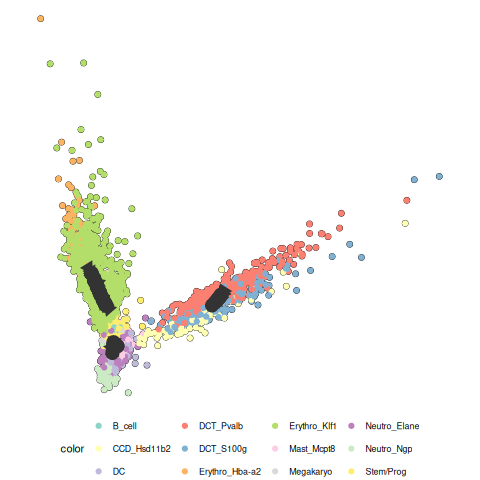

In [99]:
%%R
plot_dimred(paga_traj, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

In [123]:
%%R
paga_traj$milestone_network <- paga_traj$milestone_network[paga_traj$milestone_network$length != 0, ]
# paga_traj$milestone_network

In [124]:
%%R
paga_metrics <- calculate_metrics(
  dataset = paga_dataset,
  model = paga_traj,
  metrics = dyneval::metrics$metric_id,
  expression_source = paga_dataset$expression
)

In [125]:
%%R
cat("HIM =", paga_metrics$him, "\n")
cat("F1_branches =", paga_metrics$F1_branches, "\n")
cat("correlation =", paga_metrics$correlation, "\n")
cat("featureimp_wcor =", paga_metrics$featureimp_wcor, "\n")
paga_selected_metrics <- c(
  him = as.numeric(paga_metrics$him),
  F1_branches = paga_metrics$F1_branches,
  correlation = paga_metrics$correlation,
  featureimp_wcor = paga_metrics$featureimp_wcor
)
paga_overall_score <- exp(mean(log(paga_selected_metrics)))
cat("overall_score =", paga_overall_score, "\n")

HIM = 0.5476448 
F1_branches = 0.1566394 
correlation = 0.8056535 
featureimp_wcor = 0.4066812 
overall_score = 0.4094497 


In [100]:
%%R
dataset$counts <- Matrix::Matrix(dataset$counts, sparse = TRUE)
dataset$expression <- Matrix::Matrix(dataset$expression, sparse = TRUE)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


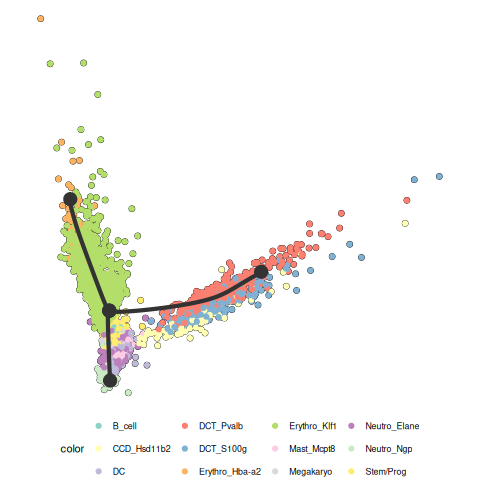

In [102]:
%%R
dpt_model <- infer_trajectory(dataset, ti_dpt(), give_priors = c("start_id"))
plot_dimred(dpt_model, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

HIM = 0.3893776 
F1_branches = 0.2951878 
correlation = 0.5696737 
featureimp_wcor = 0.7915583 
overall_score = 0.4771387 


Coloring by milestone
Using milestone_percentages from trajectory


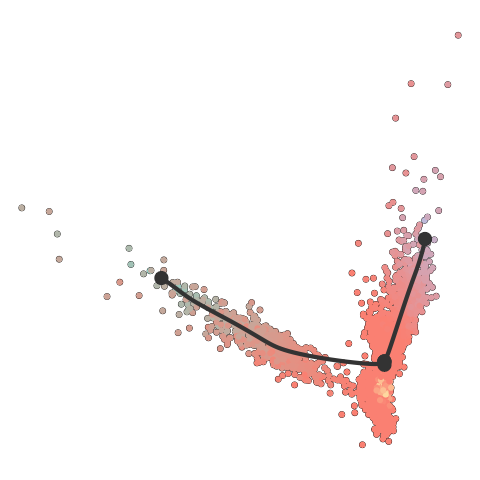

In [ ]:
%%R
dpt_model <- add_cell_waypoints(dpt_model)
dpt_metrics <- calculate_metrics(
  dataset = dataset,
  model = dpt_model,
  metrics = dyneval::metrics$metric_id,
  expression_source = dataset$expression
)
cat("HIM =", dpt_metrics$him, "\n")
cat("F1_branches =", dpt_metrics$F1_branches, "\n")
cat("correlation =", dpt_metrics$correlation, "\n")
cat("featureimp_wcor =", dpt_metrics$featureimp_wcor, "\n")
dpt_selected_metrics <- c(
  him = as.numeric(dpt_metrics$him),
  F1_branches = dpt_metrics$F1_branches,
  correlation = dpt_metrics$correlation,
  featureimp_wcor = dpt_metrics$featureimp_wcor
)
dpt_overall_score <- exp(mean(log(dpt_selected_metrics)))
cat("overall_score =", dpt_overall_score, "\n")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


You can run this method as an R wrapper (1, default) or as a container (2)
Which do you want to use? This option will be saved in options(dynwrap_backend = c('r_wrapper', 'container'))
1: R wrapper [default]
2: Container
Following packages have to be installed: tislingshot
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'tislingshot' from a github remote, the SHA1 (65248eca) has not changed since last install.
  Use `force = TRUE` to force installation


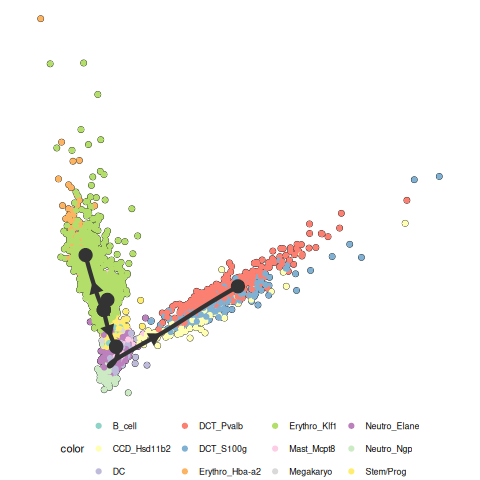

In [104]:
%%R
slingshot_model <- infer_trajectory(dataset, ti_slingshot(), give_priors = c("start_id"))
plot_dimred(slingshot_model, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

HIM = 0.4448749 
F1_branches = 0.2687963 
correlation = 0.8653428 
featureimp_wcor = 0.7865827 
overall_score = 0.5341318 


You can run this method as an R wrapper (1, default) or as a container (2)
Which do you want to use? This option will be saved in options(dynwrap_backend = c('r_wrapper', 'container'))
1: R wrapper [default]
2: Container
Following packages have to be installed: tislingshot
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'tislingshot' from a github remote, the SHA1 (65248eca) has not changed since last install.
  Use `force = TRUE` to force installation
Coloring by milestone
Using milestone_percentages from trajectory


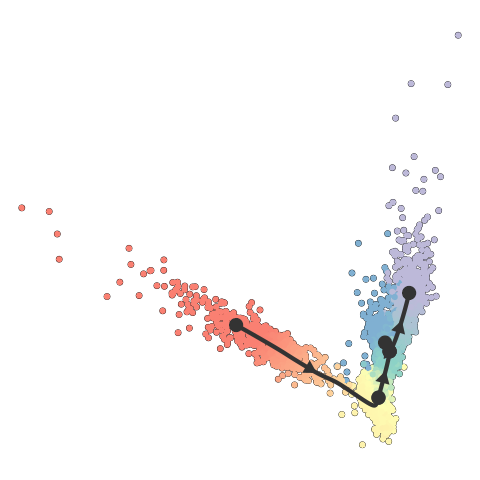

In [ ]:
%%R
slingshot_model <- add_cell_waypoints(slingshot_model)
slingshot_metrics <- calculate_metrics(
  dataset = dataset,
  model = slingshot_model,
  metrics = dyneval::metrics$metric_id,
  expression_source = dataset$expression
)
cat("HIM =", slingshot_metrics$him, "\n")
cat("F1_branches =", slingshot_metrics$F1_branches, "\n")
cat("correlation =", slingshot_metrics$correlation, "\n")
cat("featureimp_wcor =", slingshot_metrics$featureimp_wcor, "\n")
slingshot_selected_metrics <- c(
  him = as.numeric(slingshot_metrics$him),
  F1_branches = slingshot_metrics$F1_branches,
  correlation = slingshot_metrics$correlation,
  featureimp_wcor = slingshot_metrics$featureimp_wcor
)
slingshot_overall_score <- exp(mean(log(slingshot_selected_metrics)))
cat("overall_score =", slingshot_overall_score, "\n")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


Following packages have to be installed: SCORPIUS
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'SCORPIUS' from a github remote, the SHA1 (a0a97907) has not changed since last install.
  Use `force = TRUE` to force installation


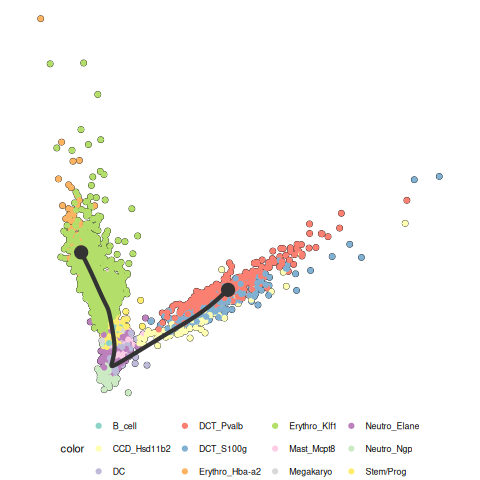

In [105]:
%%R
scorpius_model <- infer_trajectory(dataset, ti_scorpius(), give_priors = c("start_id"))
plot_dimred(scorpius_model, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

HIM = 0.2715863 
F1_branches = 0.2287983 
correlation = 0.8685246 
featureimp_wcor = 0.9409488 
overall_score = 0.4747087 


Following packages have to be installed: SCORPIUS
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'SCORPIUS' from a github remote, the SHA1 (a0a97907) has not changed since last install.
  Use `force = TRUE` to force installation
Coloring by milestone
Using milestone_percentages from trajectory


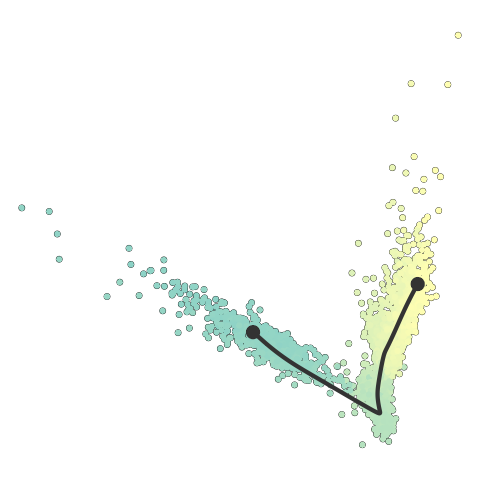

In [ ]:
%%R
scorpius_model <- add_cell_waypoints(scorpius_model)
scorpius_metrics <- calculate_metrics(
  dataset = dataset,
  model = scorpius_model,
  metrics = dyneval::metrics$metric_id,
  expression_source = dataset$expression
)
cat("HIM =", scorpius_metrics$him, "\n")
cat("F1_branches =", scorpius_metrics$F1_branches, "\n")
cat("correlation =", scorpius_metrics$correlation, "\n")
cat("featureimp_wcor =", scorpius_metrics$featureimp_wcor, "\n")
scorpius_selected_metrics <- c(
  him = as.numeric(scorpius_metrics$him),
  F1_branches = scorpius_metrics$F1_branches,
  correlation = scorpius_metrics$correlation,
  featureimp_wcor = scorpius_metrics$featureimp_wcor
)
scorpius_overall_score <- exp(mean(log(scorpius_selected_metrics)))
cat("overall_score =", scorpius_overall_score, "\n")

In [ ]:
%%R -o via_metrics -o marg_metrics -o pal_metrics -o paga_metrics -o dpt_metrics -o slingshot_metrics -o scorpius_metrics
print('outputs')

[1] "outputs"


In [ ]:
# List of dataframes to combine
dataframes = [
    via_metrics, marg_metrics, pal_metrics, paga_metrics, dpt_metrics, slingshot_metrics, scorpius_metrics
]

# Find all unique columns across all dataframes
all_columns = set().union(*(df.columns for df in dataframes))

# Ensure all dataframes have the same columns, filling missing ones with 0
aligned_dataframes = [
    df.reindex(columns=all_columns, fill_value=0) if df is pal_metrics else df
    for df in dataframes
]

# Combine all dataframes
combined_metrics = pd.concat(aligned_dataframes, ignore_index=True)
combined_metrics.index = ['Via', 'Margaret', 'Palantir', 'PAGA', 'DPT', 'Slingshot', 'Scorpius']

In [10]:
combined_metrics.to_csv("combined_metrics_mouse.csv", index=True)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

combined_metrics = pd.read_csv("combined_metrics_mouse.csv", index_col=0)
combined_metrics

,correlation,edge_flip,him,isomorphic,rf_mse,rf_nmse,rf_rsq,lm_nmse,lm_mse,lm_rsq,...,time_waypointedgeodesic,time_correlation,time_edge_flip,time_him,time_isomorphic,time_pp,time_featureimp,time_featureimp_enrichment,time_mapping_branches,time_mapping_milestones
Via,0.914812,0.0,0.672563,0.0,0.006204,0.860897,0.708153,0.866362,0.005960,0.714422,...,2.147576,0.098089,0.159398,0.148255,0.000874,30.413445,90.304322,57.511854,0.735773,0.763896
Margaret,0.528631,0.0,0.471205,0.0,0.011501,0.742129,0.548228,0.776103,0.009985,0.573924,...,1.128371,0.106020,0.119725,0.079145,0.000101,12.456528,46.898966,18.691491,0.632404,0.626698
Palantir,0.000000,0.0,0.271586,0.0,0.022392,0.497920,0.242255,0.265594,0.032754,0.149227,...,0.000000,0.000000,0.086524,0.111018,0.000615,35.592547,48.110823,17.457023,0.730813,0.724589
PAGA,0.805653,0.0,0.547645,0.0,0.007591,0.829784,0.669452,0.859052,0.006286,0.759006,...,2.404588,0.162162,0.095980,0.097453,0.000098,34.792666,109.248767,81.513637,0.805417,0.797130
DPT,0.569674,0.0,0.389378,0.0,0.024233,0.456637,0.265007,0.370240,0.028086,0.205814,...,3.666027,0.286022,0.046241,0.106974,0.000315,16.714999,51.886415,22.728004,0.709274,0.696747
Slingshot,0.865343,0.0,0.444875,0.0,0.018392,0.587618,0.375184,0.443986,0.024797,0.251692,...,3.658965,0.334937,0.045953,0.045065,0.000119,19.256332,55.953092,26.932028,0.736464,0.766763
Scorpius,0.868525,0.0,0.271586,0.0,0.021825,0.510634,0.212220,0.385381,0.027411,0.217465,...,7.894480,0.340929,0.050861,0.046302,0.000108,24.240393,43.454866,13.191875,0.707695,0.709866


In [4]:
from scipy.stats import gmean

selected_metrics = combined_metrics[['him', 'F1_branches', 'correlation', 'featureimp_wcor']].copy()
selected_metrics.loc['Palantir', 'correlation'] = selected_metrics[selected_metrics.index != 'Palantir']['correlation'].mean()
selected_metrics['Overall Score'] = selected_metrics.apply(gmean, axis=1)
selected_metrics.rename(columns={'him': 'HIM', 'correlation': 'Correlation', 'featureimp_wcor': 'Featureimp_wcor'}, inplace=True)
selected_metrics

,HIM,F1_branches,Correlation,Featureimp_wcor,Overall Score
Via,0.672563,0.386958,0.914812,0.577282,0.608876
Margaret,0.471205,0.369135,0.528631,0.886014,0.534253
Palantir,0.271586,0.228798,0.758773,0.886519,0.452158
PAGA,0.547645,0.156639,0.805653,0.406681,0.409450
DPT,0.389378,0.295188,0.569674,0.791558,0.477139
Slingshot,0.444875,0.268796,0.865343,0.786583,0.534132
Scorpius,0.271586,0.228798,0.868525,0.940949,0.474709


In [5]:
# Identify columns that start with 'time_'
time_columns = [col for col in combined_metrics.columns if col.startswith('time_')]

# Identify other columns
other_columns = [col for col in combined_metrics.columns if not col.startswith('time_')]

# Reorder the columns
reordered_columns = other_columns + time_columns

# Reorder the DataFrame
combined_metrics = combined_metrics[reordered_columns]
combined_metrics

,correlation,edge_flip,him,isomorphic,rf_mse,rf_nmse,rf_rsq,lm_nmse,lm_mse,lm_rsq,...,time_waypointedgeodesic,time_correlation,time_edge_flip,time_him,time_isomorphic,time_pp,time_featureimp,time_featureimp_enrichment,time_mapping_branches,time_mapping_milestones
Via,0.914812,0.0,0.672563,0.0,0.006204,0.860897,0.708153,0.866362,0.005960,0.714422,...,2.147576,0.098089,0.159398,0.148255,0.000874,30.413445,90.304322,57.511854,0.735773,0.763896
Margaret,0.528631,0.0,0.471205,0.0,0.011501,0.742129,0.548228,0.776103,0.009985,0.573924,...,1.128371,0.106020,0.119725,0.079145,0.000101,12.456528,46.898966,18.691491,0.632404,0.626698
Palantir,0.000000,0.0,0.271586,0.0,0.022392,0.497920,0.242255,0.265594,0.032754,0.149227,...,0.000000,0.000000,0.086524,0.111018,0.000615,35.592547,48.110823,17.457023,0.730813,0.724589
PAGA,0.805653,0.0,0.547645,0.0,0.007591,0.829784,0.669452,0.859052,0.006286,0.759006,...,2.404588,0.162162,0.095980,0.097453,0.000098,34.792666,109.248767,81.513637,0.805417,0.797130
DPT,0.569674,0.0,0.389378,0.0,0.024233,0.456637,0.265007,0.370240,0.028086,0.205814,...,3.666027,0.286022,0.046241,0.106974,0.000315,16.714999,51.886415,22.728004,0.709274,0.696747
Slingshot,0.865343,0.0,0.444875,0.0,0.018392,0.587618,0.375184,0.443986,0.024797,0.251692,...,3.658965,0.334937,0.045953,0.045065,0.000119,19.256332,55.953092,26.932028,0.736464,0.766763
Scorpius,0.868525,0.0,0.271586,0.0,0.021825,0.510634,0.212220,0.385381,0.027411,0.217465,...,7.894480,0.340929,0.050861,0.046302,0.000108,24.240393,43.454866,13.191875,0.707695,0.709866


In [6]:
# Normalize only time metrics
normalized_metrics = combined_metrics.copy()
normalized_metrics[time_columns] = combined_metrics[time_columns].div(combined_metrics[time_columns].max(axis=0), axis=1)
normalized_metrics

,correlation,edge_flip,him,isomorphic,rf_mse,rf_nmse,rf_rsq,lm_nmse,lm_mse,lm_rsq,...,time_waypointedgeodesic,time_correlation,time_edge_flip,time_him,time_isomorphic,time_pp,time_featureimp,time_featureimp_enrichment,time_mapping_branches,time_mapping_milestones
Via,0.914812,0.0,0.672563,0.0,0.006204,0.860897,0.708153,0.866362,0.005960,0.714422,...,0.272035,0.287712,1.000000,1.000000,1.000000,0.854489,0.826594,0.705549,0.913531,0.958308
Margaret,0.528631,0.0,0.471205,0.0,0.011501,0.742129,0.548228,0.776103,0.009985,0.573924,...,0.142932,0.310974,0.751104,0.533841,0.115143,0.349976,0.429286,0.229305,0.785188,0.786193
Palantir,0.000000,0.0,0.271586,0.0,0.022392,0.497920,0.242255,0.265594,0.032754,0.149227,...,0.000000,0.000000,0.542819,0.748829,0.703956,1.000000,0.440379,0.214161,0.907372,0.908998
PAGA,0.805653,0.0,0.547645,0.0,0.007591,0.829784,0.669452,0.859052,0.006286,0.759006,...,0.304591,0.475647,0.602143,0.657331,0.112415,0.977527,1.000000,1.000000,1.000000,1.000000
DPT,0.569674,0.0,0.389378,0.0,0.024233,0.456637,0.265007,0.370240,0.028086,0.205814,...,0.464378,0.838950,0.290095,0.721551,0.360709,0.469621,0.474938,0.278825,0.880630,0.874069
Slingshot,0.865343,0.0,0.444875,0.0,0.018392,0.587618,0.375184,0.443986,0.024797,0.251692,...,0.463484,0.982425,0.288288,0.303970,0.135880,0.541021,0.512162,0.330399,0.914388,0.961905
Scorpius,0.868525,0.0,0.271586,0.0,0.021825,0.510634,0.212220,0.385381,0.027411,0.217465,...,1.000000,1.000000,0.319081,0.312314,0.124147,0.681052,0.397761,0.161836,0.878669,0.890527


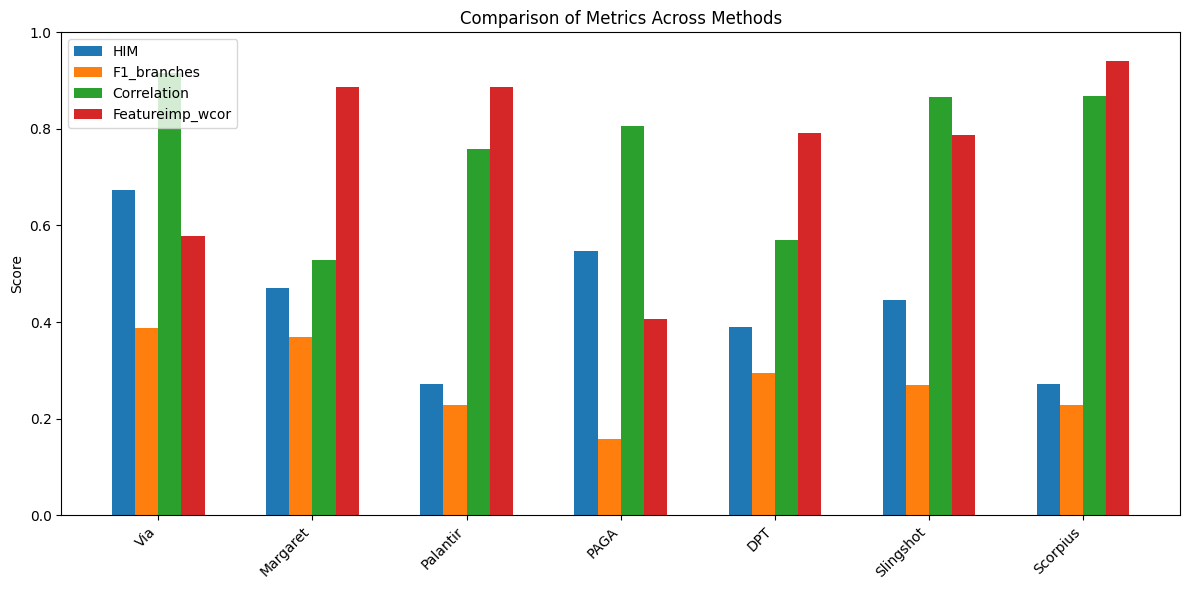

In [7]:
import pandas as pd

import matplotlib.pyplot as plt

# Assuming `metrics` is already defined as a DataFrame
columns_to_plot = ['HIM', 'F1_branches', 'Correlation', 'Featureimp_wcor']
methods = selected_metrics.index

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create the bar plot
bar_width = 0.15
x = range(len(methods))

for i, column in enumerate(columns_to_plot):
    ax.bar(
        [pos + i * bar_width for pos in x],
        selected_metrics[column],
        bar_width,
        label=column
    )

# Set x-axis labels and ticks
ax.set_xticks([pos + (len(columns_to_plot) - 1) * bar_width / 2 for pos in x])
ax.set_xticklabels(methods, rotation=45, ha='right')

# Set y-axis limits
ax.set_ylim(0, 1)

# Add labels and legend
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics Across Methods')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

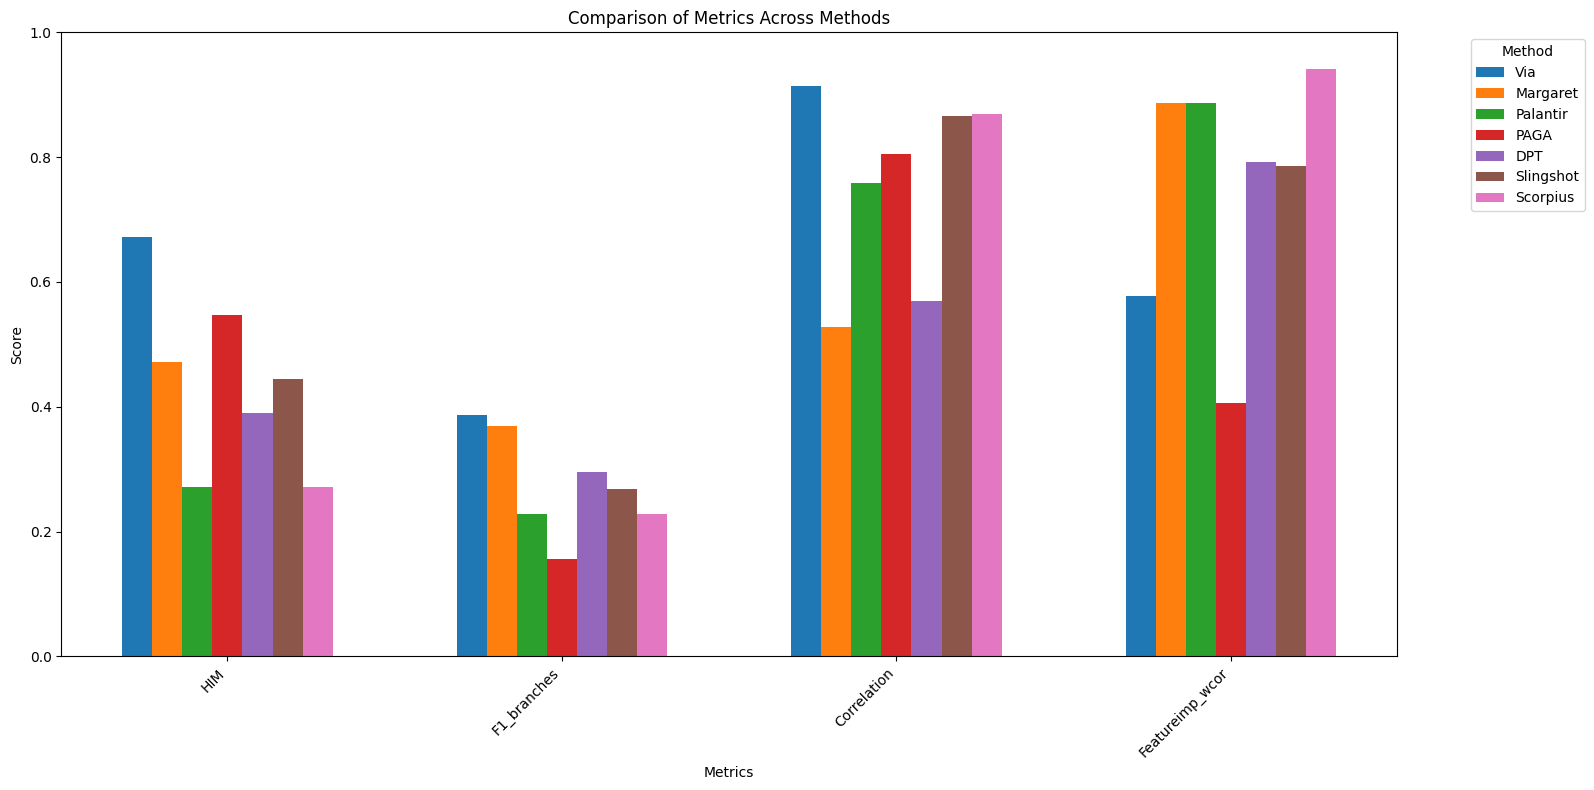

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Selected metrics (without Overall Score)
columns_to_plot = ['HIM', 'F1_branches', 'Correlation', 'Featureimp_wcor']
metrics_df = selected_metrics[columns_to_plot]

# Methods (DataFrame index)
methods = metrics_df.index.tolist()
n_metrics = len(columns_to_plot)
n_methods = len(methods)

# Create x positions for metric groups
x = np.arange(n_metrics)

# Adjust the bar width and figure size; here we use a slightly smaller width and larger figure
bar_width = 0.09

fig, ax = plt.subplots(figsize=(16, 8))

for i, method in enumerate(methods):
    ax.bar(x + i * bar_width,
           metrics_df.loc[method].values,
           bar_width,
           label=method)

# Center the x-axis ticks within each group
ax.set_xticks(x + (n_methods - 1) * bar_width / 2)
ax.set_xticklabels(columns_to_plot, rotation=45, ha='right')

ax.set_ylim(0, 1)
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics Across Methods')

# Place the legend outside the plot for clarity
ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


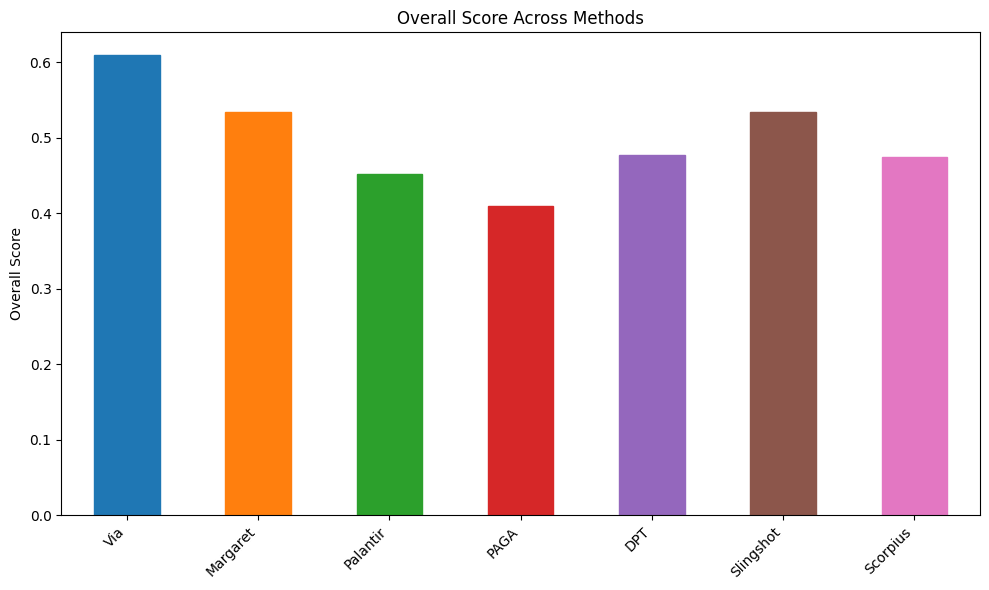

In [9]:
# Plot the Overall Score
plt.figure(figsize=(10, 6))
selected_metrics['Overall Score'].plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.ylabel('Overall Score')
plt.title('Overall Score Across Methods')
plt.xticks(rotation=45, ha='right')
# Assign the same colors to the bars as in the plot above
colors = plt.cm.tab10(range(len(selected_metrics)))
for bar, color in zip(plt.gca().patches, colors):
    bar.set_color(color)
# Show the plot
plt.tight_layout()
plt.show()

In [10]:
selected_metrics.to_csv("selected_metrics_mouse.csv", index=True)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

selected_metrics = pd.read_csv("selected_metrics_mouse.csv", index_col=0)
selected_metrics

,HIM,F1_branches,Correlation,Featureimp_wcor,Overall Score
Via,0.672563,0.386958,0.914812,0.577282,0.608876
Margaret,0.471205,0.369135,0.528631,0.886014,0.534253
Palantir,0.271586,0.228798,0.758773,0.886519,0.452158
PAGA,0.547645,0.156639,0.805653,0.406681,0.409450
DPT,0.389378,0.295188,0.569674,0.791558,0.477139
Slingshot,0.444875,0.268796,0.865343,0.786583,0.534132
Scorpius,0.271586,0.228798,0.868525,0.940949,0.474709
